# Experimentación con técnicas de agrupamiento

## Autor: Pablo Fuentes Jiménez



---

## Información acerca del problema

### Dataset
 Para la realización de este ejercicio, se ha seleccionado el dataset denominado "Anuran Calls (MFCCs)" [1] (https://archive.ics.uci.edu/dataset/406/anuran+calls+mfccs). Este conjunto de datos describe las características sonoras de los cantos de diferentes especies de anfibios del orden Anura, cuyos integrantes coloquialmente son conocidos como ranas o sapos.

Se encuentran representados por medio de los coeficientes cepstrales en las frecuencias de Mel ([_Mel-frequency cepstral coefficients_](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), MFCCs), que son en esencia, una representación abstracta de una señal de audio obtenida al aplicar una transformada del coseno discreta a un espectrograma de Mel, es decir, una representación  de las frecuencias auditivas que son capaces de captar los humanos. Debido a ser una representación compacta del [espectrograma](https://en.wikipedia.org/wiki/Spectrogram), manteniendo las características más importantes del audio, se utiliza de forma regular en procesado del habla y aplicaciones de aprendizaje automático en procesado de señales de audio [2].

El dataset, creado por investigadores de la Universidad Federal del Amazonas en Brasil, contiene individuos de 10 especies, también incluyéndose su género y familia taxonómica, con el objetivo original de lograr realizar una clasificación multiclase de las especies de anuros que fueron grabados en los terrenos de la Universidad, así como de Mata atlántica (Brasil) y Córdoba (Argentina) en condiciones reales, es decir, con ruido de fondo.
    
Este conjunto de datos se utilizó en varias tareas de clasificación relacionadas con el reto del reconocimiento de especies de anuros a través de sus llamadas. Se trata de un conjunto de datos multietiqueta con tres columnas de etiquetas. Este conjunto de datos se creó segmentando 60 registros de audio pertenecientes a 4 familias diferentes, 8 géneros y 10 especies. Cada audio corresponde a un espécimen (una rana individual), el ID del registro también se incluye como columna adicional. Se utilizaron la entropía espectral y un método de cluster binario para detectar los fragmentos de audio pertenecientes a cada sonido. La segmentación y la extracción de características se realizaron en Matlab. Tras la segmentación se obtuvieron 7195 sílabas, que se convirtieron en instancias para entrenar y probar el clasificador.

Resulta entonces interesante saber si las clasificaciones taxonómicas realizadas tienen sentido en cuanto a los datos, es decir, ¿realmente se corresponden de cierta forma los distintos cantos de los anuros con la clasificación que poseen actualmente? ¿O existen especies que, siendo de diferentes grupos taxonómicos, poseen un canto indistinguible?


### Objetivos
    
El objetivo del presente trabajo es analizar los patrones de los datos, sin tomar en cuenta su _ground truth_, para determinar si la clasificación taxonómica actual corresponde razonablemente con una diferencia en los cantos. Claro está que este estudio representará un análisis superficial del problema, pero al menos sí podrá servir de base para estudiar si podemos determinar una taxonomía aproximada de los anuros.

Para llevar a cabo este objetivo principal se llevarán a cabo los siguientes objetivos secundarios:
1. Realización de un análisis exploratorio de los datos para una primera observación de las distribuciones de los cantos.
2. Detección y eliminación de _outliers_ así como las transformaciones necesarias para que los datos sean lo más "correctos" para los métodos de _clustering_.
4. Experimentación y determinación de los algoritmos y métricas intrínsecas más acordes a los datos.

### Hipótesis
Sobre los datos se pueden realizar las siguientes hipótesis:
- Los datos, siendo grabaciones que incluyen el ruido de fondo, poseerán una cantidad significativa de _outliers_.
- Será posible, al menos en parte, observar cierta "agrupación" en los datos a simple vista.
- Existirá cierta correlación entre los _MFCCs_ debido a que provienen de una misma grabación, por lo que ciertas columnas/características crecerán o disminuirán de forma conjunta. En otras palabras, como el dispositivo empleado para adquirir sonidos es el mismo para todas las pistas de audio (7195), es razonable pensar que si algún _MFCC_ presenta algún problema, o atenuación de algún tipo, dicha particularidad podrá estar presente en todas las instancias/observaciones.  

### Resultados Esperados
Se espera que los resultados que se obtengan del clustering sean razonablemente parecidos a la realidad. Es decir, se espera que el agrupamiento encontrado tenga algún tipo de relación con alguna de las últimas 4 columnas de los datos (_Family_, _Genus_, _Species_ o _RecordID_).

## Trabajo realizado

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from google.colab import drive
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

# Fijamos la semilla aleatoria
np.random.seed(42)

# Cambiamos aspecto de los gráficos
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
# Para acceder a nuestros ficheros de Google Drive
drive.mount('/content/drive')
dataFolder = 'drive/MyDrive/Colab Notebooks/clustering/'

Mounted at /content/drive


In [3]:
df_frogs = pd.read_csv(dataFolder + "/dataset/Frogs_MFCCs.csv")
features = df_frogs.drop(columns=['Family', 'Genus', 'Species', 'RecordID'])
labels = df_frogs['RecordID']
family = df_frogs['Family']
genus = df_frogs['Genus']
species = df_frogs['Species']

### Análisis exploratorio

#### Análisis estadístico básico

Para comenzar con el análisis exploratorio, vamos a tratar de observar la distribución de las distintas grabaciones, tanto en función de especie, como de su familia y de su género, y además en función del ID del registro.

##### Visualización de las etiquetas

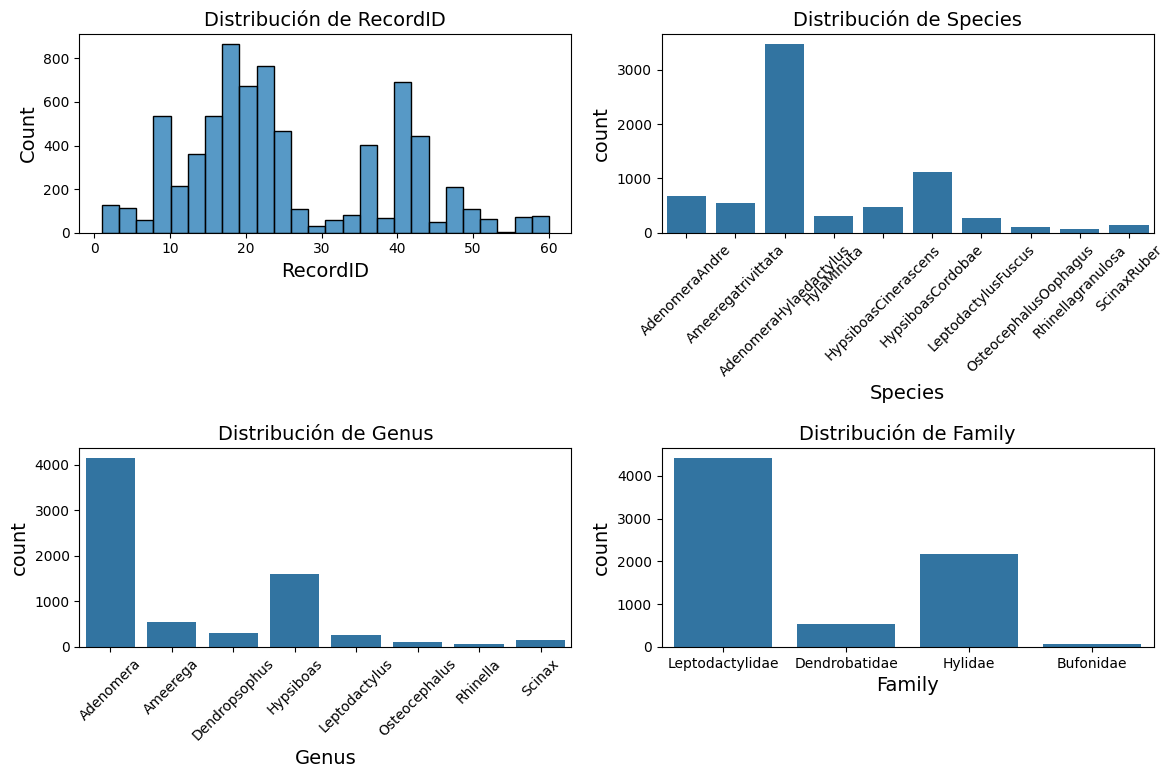

In [4]:
# Columnas a graficar
columns_to_plot = ['RecordID', 'Species', 'Genus', 'Family']

# Crea la figura y los ejes para la cuadrícula
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 filas, 2 columnas

# Itera a través de las columnas y grafica en la cuadrícula
for i, col in enumerate(columns_to_plot):
    row = i // 2
    col_index = i % 2

    if col in ['RecordID']:
        sns.histplot(df_frogs[col], fill=True, ax=axes[row, col_index])
    else:
        sns.countplot(x=df_frogs[col], ax=axes[row, col_index])

    axes[row, col_index].set_title(f"Distribución de {col}")

    if col in ['Species', 'Genus']:
        axes[row, col_index].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Si observamos los histogramas realizados para cada una de las 4 variables distintas, vemos que ninguna de ellas está uniformemente distribuida, apareciendo para cada una categorías con frecuencias muy dispares, con unas diferencias muy grandes entre las frecuencias.

##### Visualización detallada de características individuales

A continuación, vamos a observar el resto de variables de forma independiente, viendo la distribución que tienen y los posibles outliers que puedan aparecer.


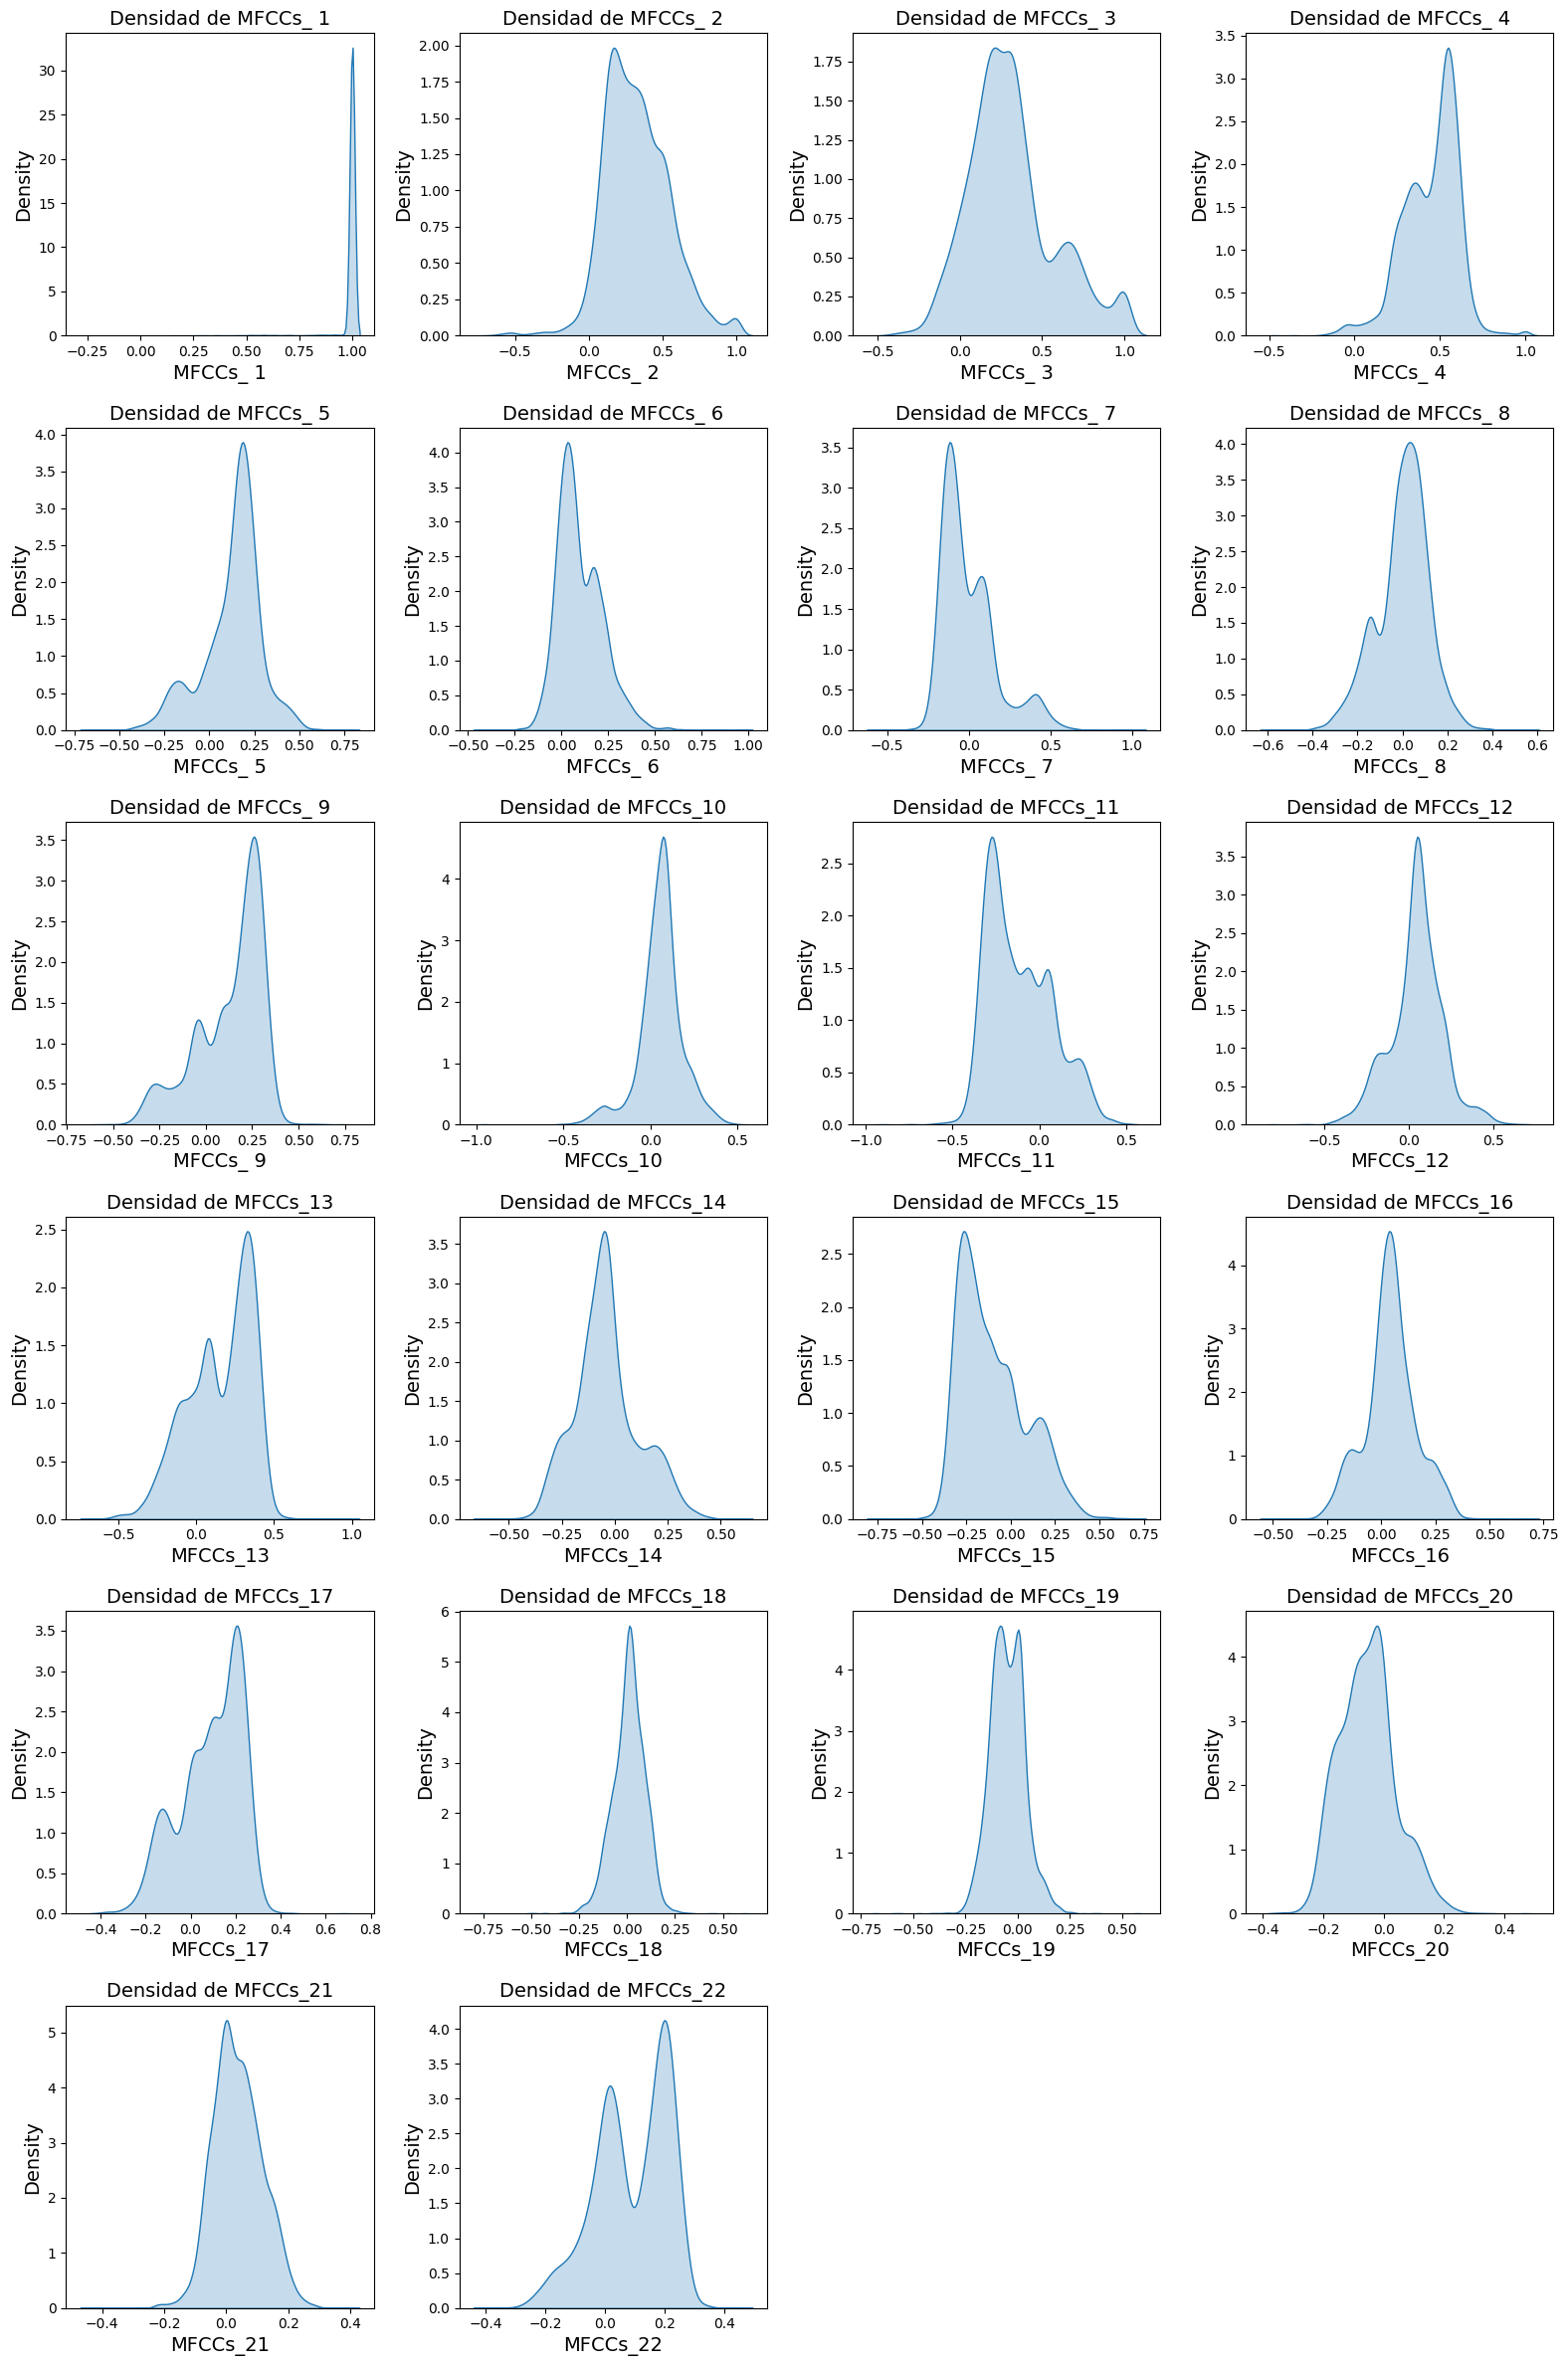

In [5]:
# Calcula el número de filas necesarias para la cuadrícula
num_cols = 4
num_rows = math.ceil(len(features.columns) / num_cols)

# Crea la figura y los ejes para la cuadrícula
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))

# Aplana el array de ejes para facilitar la iteración
axes = axes.flatten()

# Itera a través de las características y grafica en la cuadrícula
for i, col in enumerate(features.columns):
    sns.kdeplot(features[col], fill=True, ax=axes[i])
    axes[i].set_title(f"Densidad de {col}")
    axes[i].set_xlabel(col)

# Oculta cualquier subplot vacío si el número de características no es divisible por 4
for i in range(len(features.columns), num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
print("Resumen estadístico:")
print(features.describe())

Resumen estadístico:
          MFCCs_ 1     MFCCs_ 2     MFCCs_ 3     MFCCs_ 4     MFCCs_ 5  \
count  7195.000000  7195.000000  7195.000000  7195.000000  7195.000000   
mean      0.989885     0.323584     0.311224     0.445997     0.127046   
std       0.069016     0.218653     0.263527     0.160328     0.162722   
min      -0.251179    -0.673025    -0.436028    -0.472676    -0.636012   
25%       1.000000     0.165945     0.138445     0.336737     0.051717   
50%       1.000000     0.302184     0.274626     0.481463     0.161361   
75%       1.000000     0.466566     0.430695     0.559861     0.222592   
max       1.000000     1.000000     1.000000     1.000000     0.752246   

          MFCCs_ 6     MFCCs_ 7     MFCCs_ 8     MFCCs_ 9     MFCCs_10  ...  \
count  7195.000000  7195.000000  7195.000000  7195.000000  7195.000000  ...   
mean      0.097939    -0.001397    -0.000370     0.128213     0.055998  ...   
std       0.120412     0.171404     0.116302     0.179008     0.127099  ...

Si observamos las gráficas en primer lugar, vemos que las variables presentan unas distribuciones similares en cuanto a la variabilidad, aunque se centran en valores distintos, siendo tanto positivos como negativos. Concretamente destaca la variable 1 que tiene la mejor varianza y además, sus valores son todos muy próximo al valor 1.

Esto lo vamos a relacionar con el resumen estadístico que hemos realizado, donde se reafirma lo anterior, y además se observa que la variable 1 permite que los percentiles tomen valores anómalos en solo un caso, tomando el valor 1.

Además, destaca que todas las variables toman tanto valores positivos como negativos como se observa con las métricas del mínimo y el máximo.

Por último, destacar que como el dataset no presenta ningún dato faltante, no será necesaria incluir ninguna acción para tratar con estos.

##### Visualización de la matriz de correlación

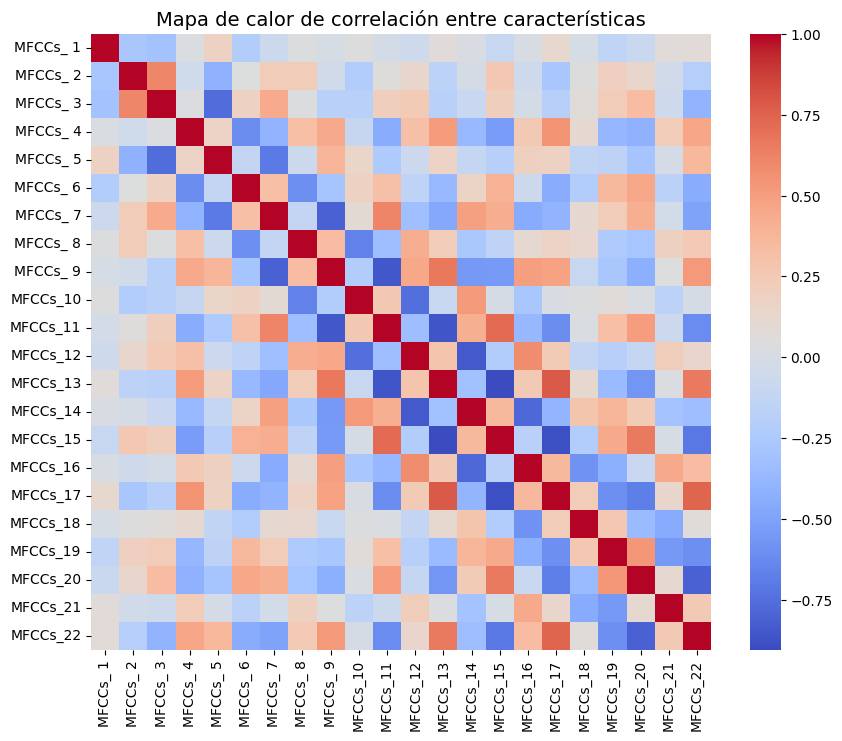

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(features.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de calor de correlación entre características")
plt.show()

Si examinamos la matriz de correlación generada, observamos que algunos atributos del conjunto de datos muestran relaciones significativas entre sí. Esta matriz nos permite identificar patrones de dependencia, donde una correlación positiva indica que dos variables tienden a aumentar o disminuir juntas, mientras que una correlación negativa sugiere que, al aumentar una variable, la otra tiende a disminuir.

A pesar de identificar algunas relaciones entre atributos, no se observa ninguna agrupación clara o patrones de alta correlación que permitan deducir componentes que expliquen una gran parte de la varianza de los datos. En otras palabras, aunque ciertos pares de variables están correlacionados, no es suficiente para identificar factores latentes o componentes subyacentes que simplifiquen la estructura del dataset. Esta falta de correlación fuerte y consistente sugiere que los atributos son en su mayoría independientes o, al menos, no lo suficientemente correlacionados para justificar la reducción de dimensionalidad mediante un simple análisis de componentes principales basado exclusivamente en la correlación.

Para profundizar en este aspecto, sería ideal aplicar métodos de reducción de dimensionalidad, como el Análisis de Componentes Principales (PCA) o el Mapeo Estocástico de Vecinos T-distribuido (t-SNE), que pueden ayudar a descubrir si existen componentes subyacentes, aunque no sean inmediatamente evidentes en la matriz de correlación. Estos métodos permiten transformar las variables originales en nuevas variables (componentes) que pueden capturar la mayor variabilidad del conjunto de datos, facilitando la identificación de posibles patrones ocultos o relaciones más complejas entre los atributos.

#### Detección y tratamiento de outliers

Para tratar de detectar los outliers, aplicaremos los cuatro algoritmos descritos en la práctica sobre el dataset, sin tener en cuenta las 4 últimas variables, ya que son aquellas que podrían servir para agrupar las instancias de las grabaciones.

In [8]:
# Utilizamos el dataset sin las últimas 4 variables
df_clean = features

# Detección de outliers con K Nearest Neighbors (KNN)
knn = NearestNeighbors(n_neighbors=20)
knn.fit(df_clean)
distances, _ = knn.kneighbors(df_clean)
mean_dist = np.mean(distances[:, 1:], axis=1)
std_dist = np.std(distances[:, 1:], axis=1)
threshold = np.mean(mean_dist) + 2 * np.mean(std_dist)
knn_outliers = (mean_dist > threshold).astype(int)
knn_outlier_indices = np.where(knn_outliers == -1)[0]

# Detección de outliers con Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof_outliers = lof.fit_predict(df_clean)
lof_outlier_indices = np.where(lof_outliers == -1)[0]

# Detección de outliers con One-Class SVM (OCSVM)
ocsvm = OneClassSVM(nu=0.1)
ocsvm_outliers = ocsvm.fit_predict(df_clean)
ocsvm_outlier_indices = np.where(ocsvm_outliers == -1)[0]

# Detección de outliers con Isolation Forest
iforest = IsolationForest(contamination=0.1)
iforest_outliers = iforest.fit_predict(df_clean)
iforest_outlier_indices = np.where(iforest_outliers == -1)[0]

print("Outliers detectados por KNN:", np.sum(knn_outliers == 1))
print("Outliers detectados por LOF:", np.sum(lof_outliers == -1))
print("Outliers detectados por OCSVM:", np.sum(ocsvm_outliers == -1))
print("Outliers detectados por Isolation Forest:", np.sum(iforest_outliers == -1))

Outliers detectados por KNN: 1391
Outliers detectados por LOF: 720
Outliers detectados por OCSVM: 719
Outliers detectados por Isolation Forest: 720


Tras aplicar los algoritmos, miraremos aquellos outliers que hayan sido identificados por los distintos algoritmos y eliminaremos aquellos que hayan sido identificados por al menos 2 métodos distintos, para evitar que se elimine información relevante, y para evitar eliminar un excesivo número de instancias. Con esto conseguimos evitar por ejemplo que se eliminen instancias con el algoritmo KNN que, en función de la densidad de los datos, se podría o no eliminar.

In [9]:
# Obtener los índices de outliers detectados por cada método
outliers_knn_set = set(knn_outlier_indices)
outliers_lof_set = set(lof_outlier_indices)
outliers_ocsvm_set = set(ocsvm_outlier_indices)
outliers_iforest_set = set(iforest_outlier_indices)

# Calcular outliers detectados por dos métodos distintos
outliers_2_methods = (outliers_knn_set & outliers_lof_set) | \
                     (outliers_knn_set & outliers_ocsvm_set) | \
                     (outliers_knn_set & outliers_iforest_set) | \
                     (outliers_lof_set & outliers_ocsvm_set) | \
                     (outliers_lof_set & outliers_iforest_set) | \
                     (outliers_ocsvm_set & outliers_iforest_set)
outliers_1_method = outliers_knn_set | outliers_lof_set | outliers_ocsvm_set | outliers_iforest_set

# Imprimir el número de outliers detectados por múltiples métodos
print("--------------------------------------------------------------")
print("Outliers detectados por 2 métodos:", len(outliers_2_methods))
print("Outliers detectados por 1 método:", len(outliers_1_method))

# Eliminar los outliers detectados por múltiples métodos del DataFrame original
df_clean_outliers = df_clean.drop(list(outliers_2_methods))
labels_outliers = labels.drop(list(outliers_2_methods))
species_outliers = species.drop(list(outliers_2_methods))
genus_outliers = genus.drop(list(outliers_2_methods))
family_outliers = family.drop(list(outliers_2_methods))

--------------------------------------------------------------
Outliers detectados por 2 métodos: 621
Outliers detectados por 1 método: 1342


#### Análisis exploratorio con PCA y t-SNE

La primera transformación que realizaremos sobre los datos será la reescalación, para que sea más fácil tratar con ellos. Los escalaremos de tal forma que tengan media 0 y varianza 1.

Una vez escalemos los datos, pasaremos a realizar un PCA utilizando 2 componentes principales con el objetivo de capturar la máxima variabilidad posible del conjunto de datos en un espacio 2D, permitiendo observar posibles agrupaciones y patrones en el dataset.

Posteriormente, aplicaremos un PCA pero en esta ocasión haremos uso de 3 componentes principales para visualizar una mayor cantidad de información que en la versión 2D.

Finalmente, utilizaremos el método t-SNE, ya que es un método de reducción de la dimensionalidad no lineal, con el fin de capturar y preservar la estructura local de los datos en un espacio 2D, destacando las agrupaciones que no se pueden representar completamente mediante técnicas lineales como PCA.

In [10]:
# Escalamos los datos antes de aplicar PCA y t-SNE
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_clean_outliers)

##### Visualización con PCA en 2D

In [11]:
pca_2d = PCA(n_components=2)
pca_2d_result = pca_2d.fit_transform(features_scaled)

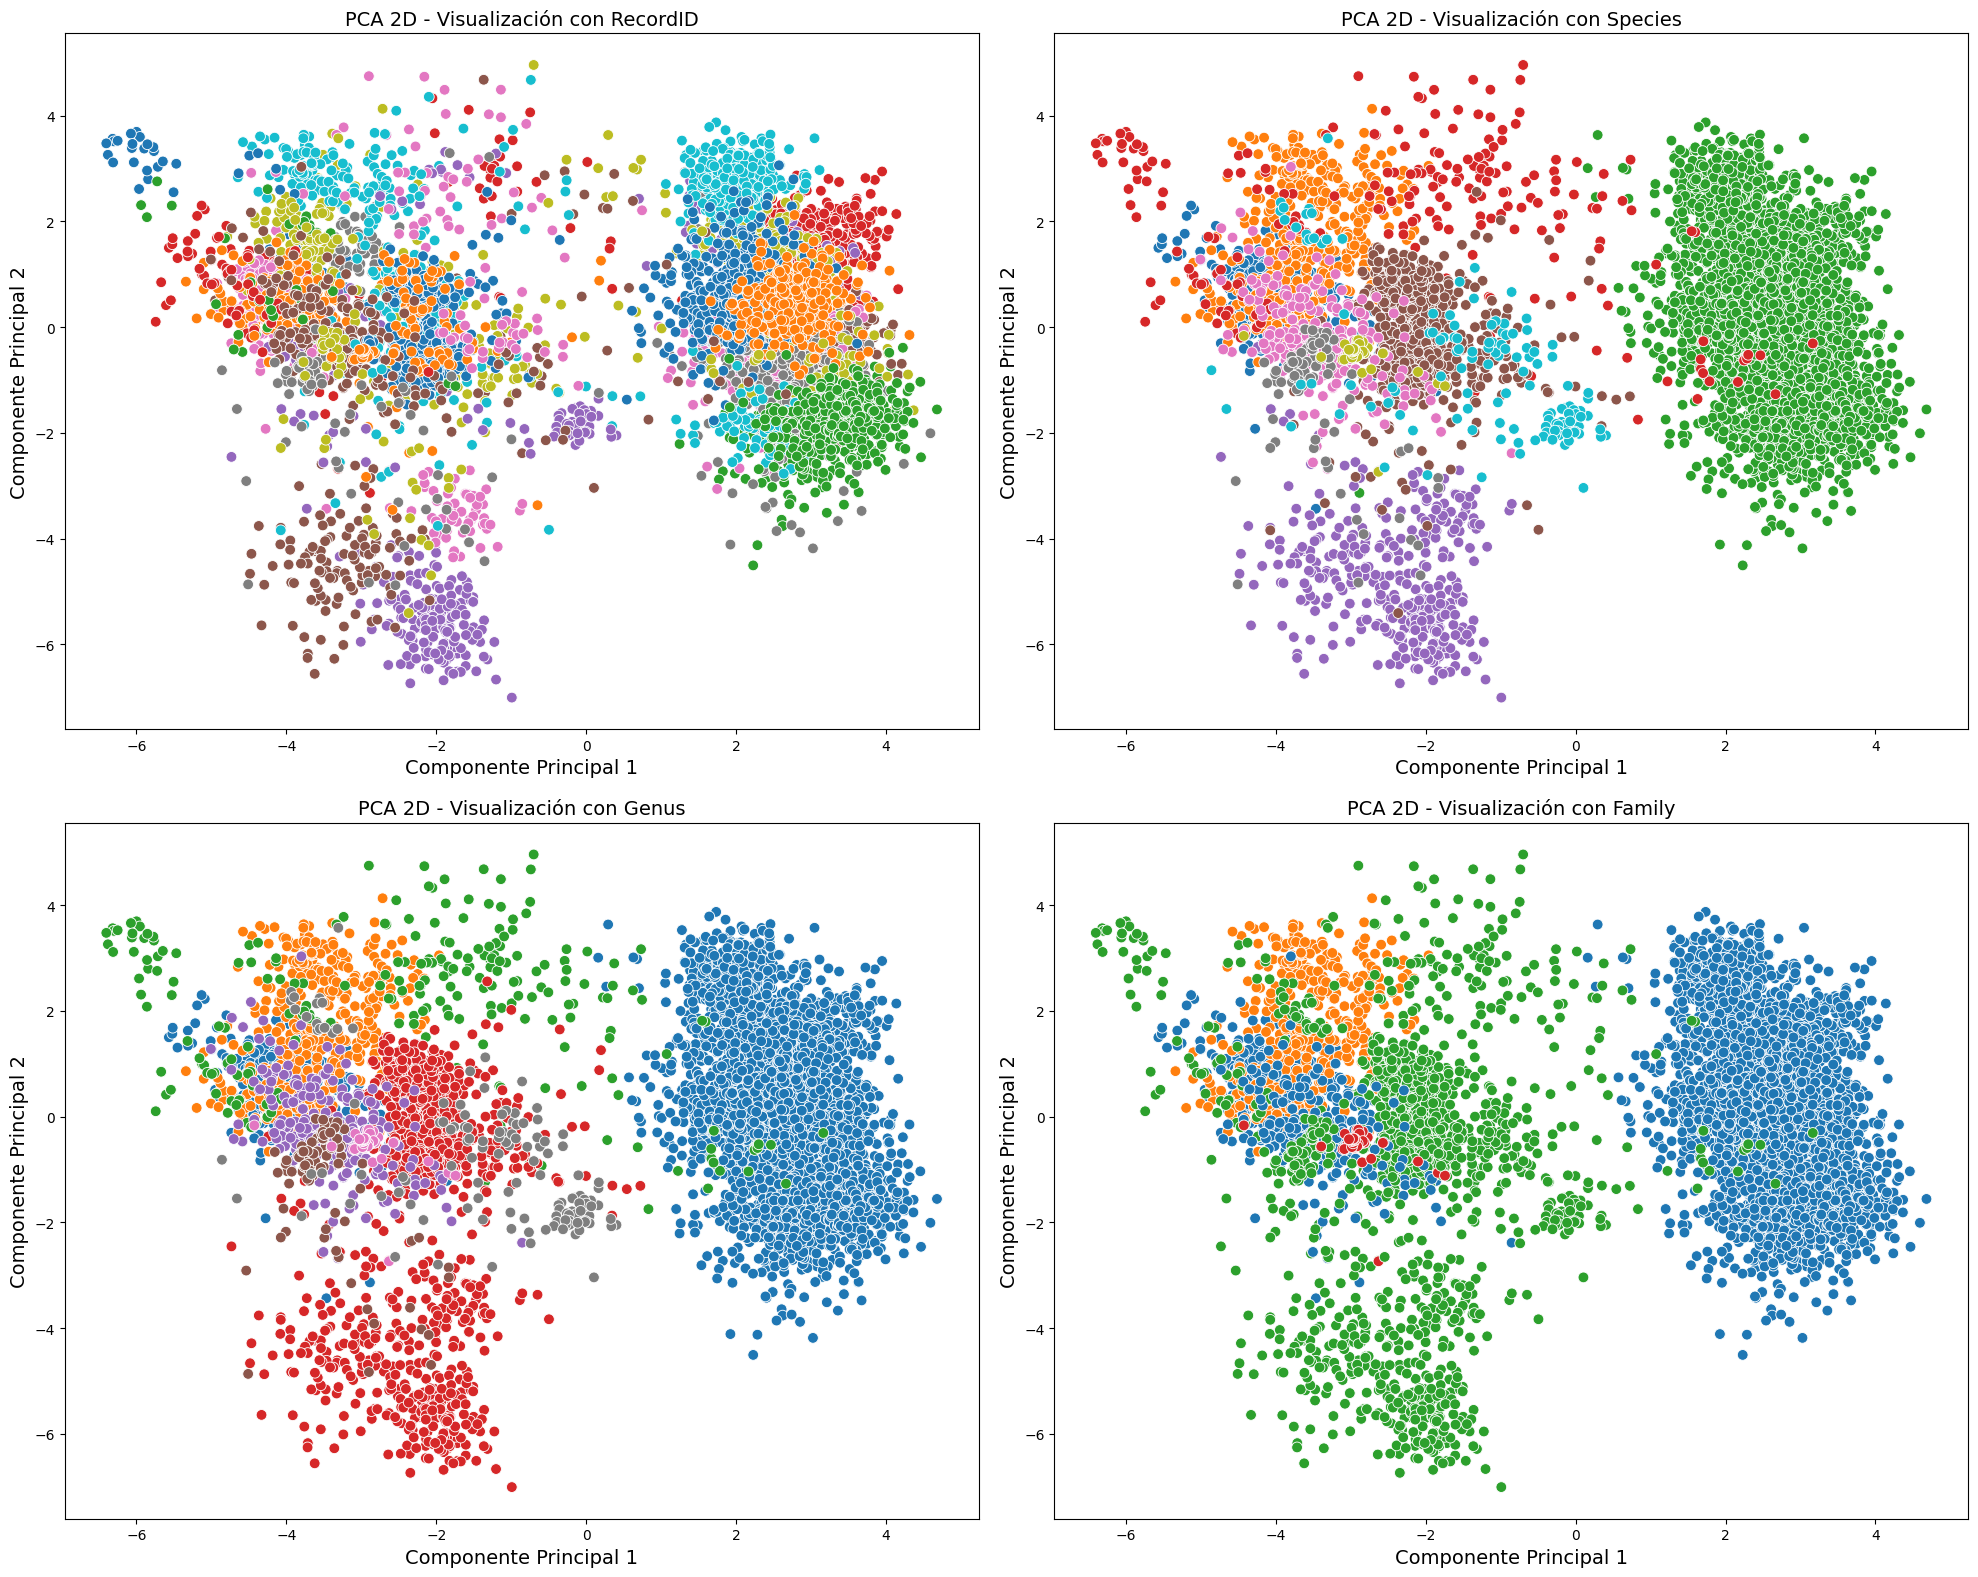

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

sns.scatterplot(x=pca_2d_result[:, 0], y=pca_2d_result[:, 1], hue=labels_outliers, palette="tab10", s=60, legend=False, ax=axes[0, 0])
axes[0, 0].set_title("PCA 2D - Visualización con RecordID")
axes[0, 0].set_xlabel("Componente Principal 1")
axes[0, 0].set_ylabel("Componente Principal 2")

sns.scatterplot(x=pca_2d_result[:, 0], y=pca_2d_result[:, 1], hue=species_outliers, palette="tab10", s=60, legend=False, ax=axes[0, 1])
axes[0, 1].set_title("PCA 2D - Visualización con Species")
axes[0, 1].set_xlabel("Componente Principal 1")
axes[0, 1].set_ylabel("Componente Principal 2")

sns.scatterplot(x=pca_2d_result[:, 0], y=pca_2d_result[:, 1], hue=genus_outliers, palette="tab10", s=60, legend=False, ax=axes[1, 0])
axes[1, 0].set_title("PCA 2D - Visualización con Genus")
axes[1, 0].set_xlabel("Componente Principal 1")
axes[1, 0].set_ylabel("Componente Principal 2")

sns.scatterplot(x=pca_2d_result[:, 0], y=pca_2d_result[:, 1], hue=family_outliers, palette="tab10", s=60, legend=False, ax=axes[1, 1])
axes[1, 1].set_title("PCA 2D - Visualización con Family")
axes[1, 1].set_xlabel("Componente Principal 1")
axes[1, 1].set_ylabel("Componente Principal 2")


plt.tight_layout()
plt.show()

Vamos a analizar los resultado del PCA 2D. La disposición de los puntos en los gráficos de dispersión nos permite observar una separación bastante clara de un grupo particular de individuos. Este grupo diferenciado podría representar una familia, género, o especie específica dentro del conjunto de datos, destacándose por características únicas que los separan del resto de los individuos en el espacio reducido.

Esta separación de un grupo concreto indica la presencia de características distintivas que definen claramente a este subconjunto, lo que puede facilitar su clasificación y análisis. Esta diferencia en el espacio reducido de PCA podría reflejar factores biológicos o ambientales que hacen que este grupo específico de ranas sea significativamente diferente en comparación con los demás.

Por otro lado, el resto de los datos se encuentran bastante mezclados en una región común del espacio, lo que sugiere una menor diferenciación en sus características principales. Aun así, es posible identificar patrones de agrupación más sutiles dentro de esta región que podrían señalar grupos de individuos que comparten ciertas similitudes en sus atributos. Estos grupos, aunque menos evidentes, pueden representar diferentes géneros de ranas con características biológicas que los acercan en el espacio de PCA pero que aún guardan ciertas diferencias internas.

Esta interpretación sugiere que PCA 2D es eficaz para capturar separaciones claras cuando existen diferencias importantes entre los individuos, pero puede ser limitado para reflejar variaciones más finas o relaciones complejas en los datos que podrían existir dentro de la región común. Es aquí donde técnicas adicionales, como PCA en 3D o t-SNE, podrían ayudar a captar patrones más complejos o diferencias sutiles en los datos.

##### Visualización con PCA en 3D

In [13]:
pca_3d = PCA(n_components=3)
pca_3d_result = pca_3d.fit_transform(features_scaled)

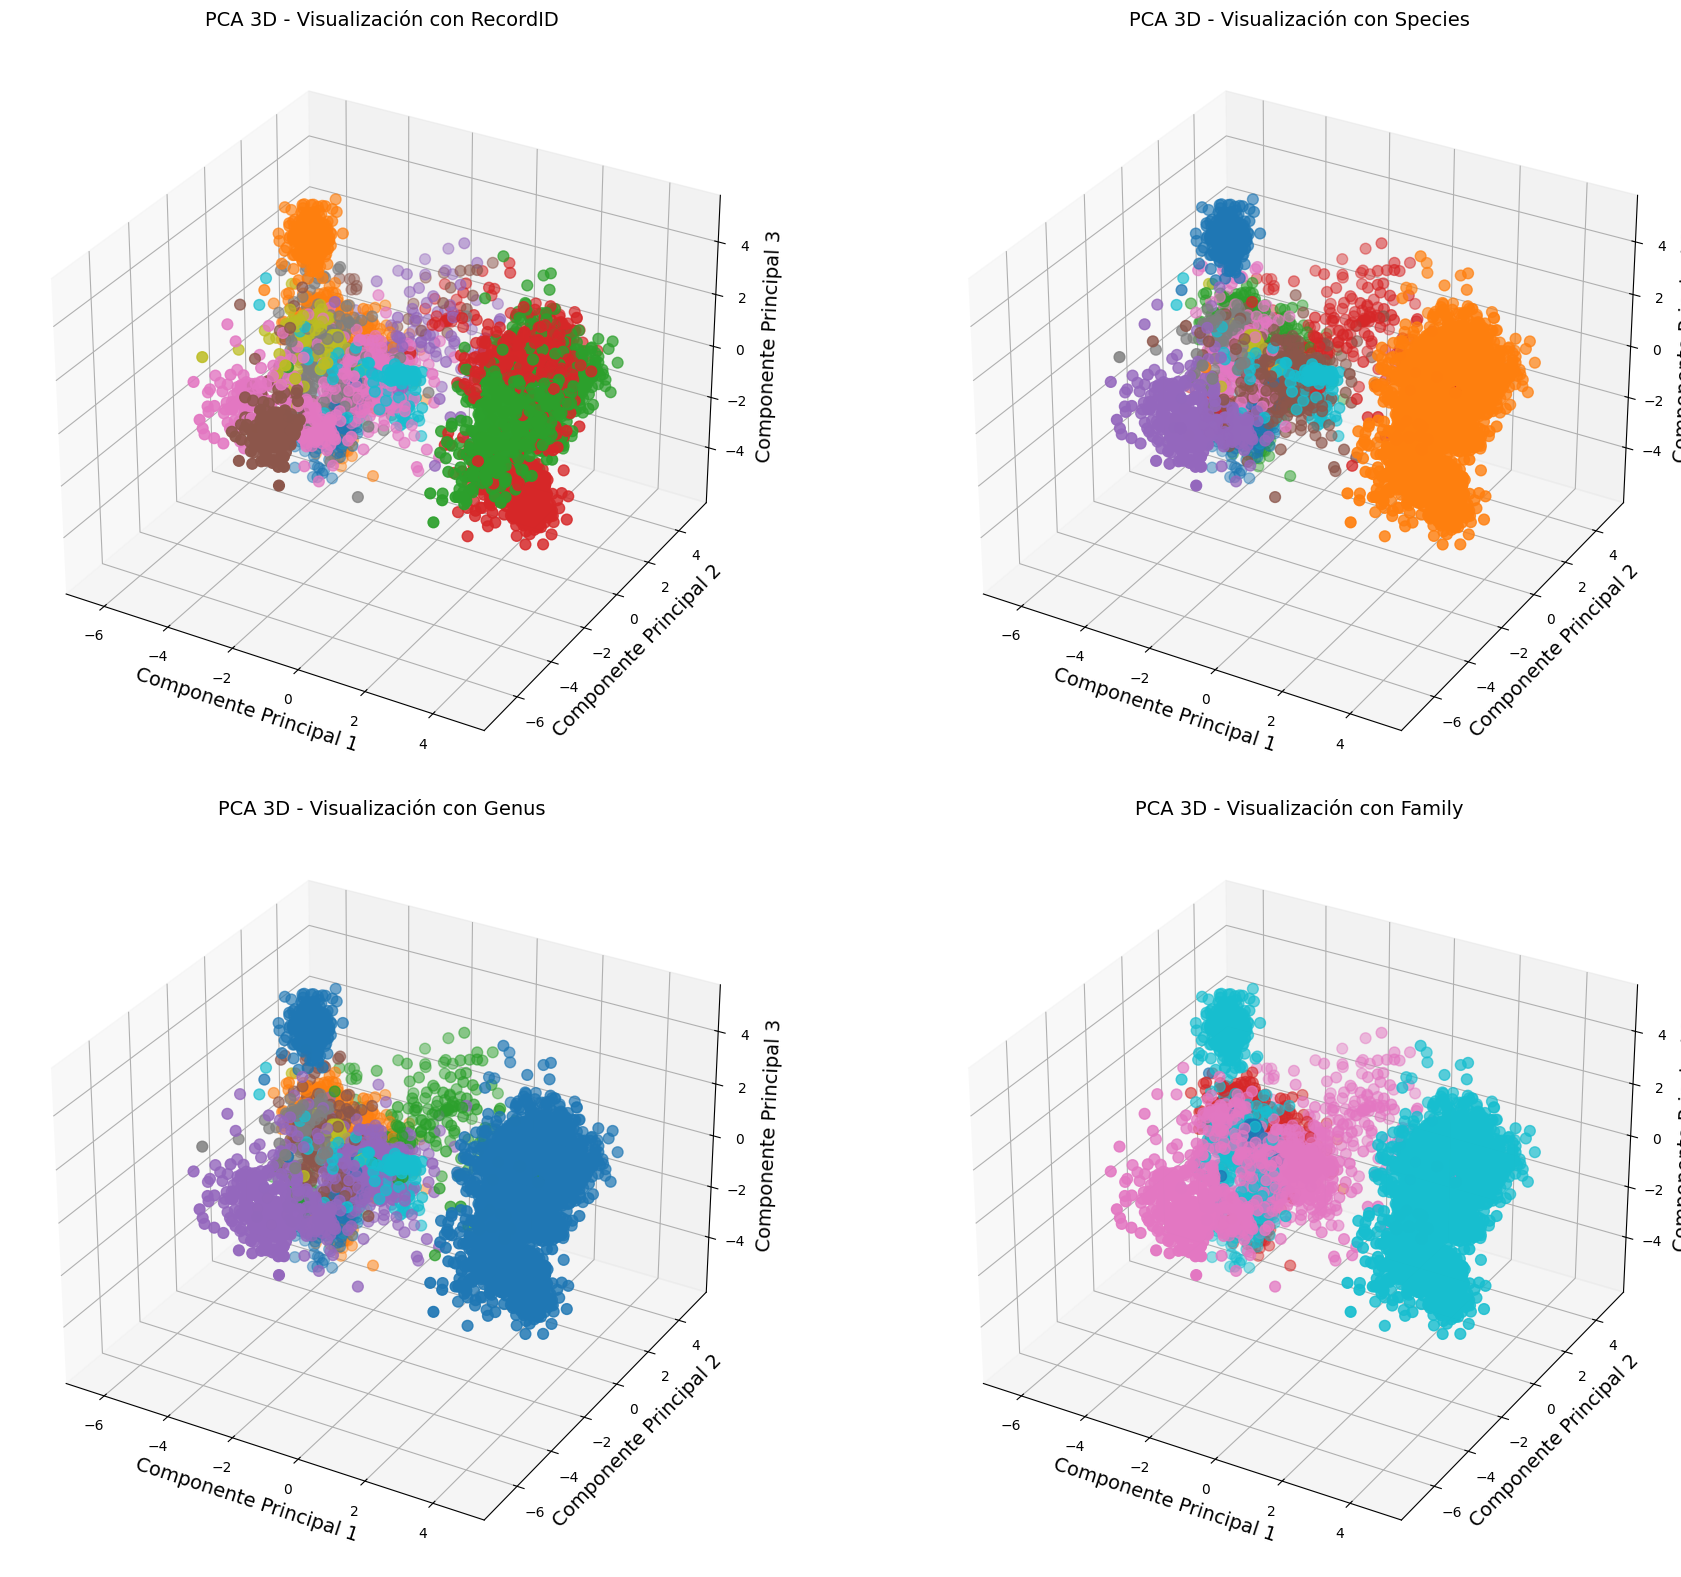

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16), subplot_kw={'projection': '3d'})

axes[0, 0].scatter(pca_3d_result[:, 0], pca_3d_result[:, 1], pca_3d_result[:, 2], c=labels_outliers.astype('category').cat.codes, cmap='tab10', s=60)
axes[0, 0].set_title("PCA 3D - Visualización con RecordID")
axes[0, 0].set_xlabel("Componente Principal 1")
axes[0, 0].set_ylabel("Componente Principal 2")
axes[0, 0].set_zlabel("Componente Principal 3")

axes[0, 1].scatter(pca_3d_result[:, 0], pca_3d_result[:, 1], pca_3d_result[:, 2], c=species_outliers.astype('category').cat.codes, cmap='tab10', s=60)
axes[0, 1].set_title("PCA 3D - Visualización con Species")
axes[0, 1].set_xlabel("Componente Principal 1")
axes[0, 1].set_ylabel("Componente Principal 2")
axes[0, 1].set_zlabel("Componente Principal 3")

axes[1, 0].scatter(pca_3d_result[:, 0], pca_3d_result[:, 1], pca_3d_result[:, 2], c=genus_outliers.astype('category').cat.codes, cmap='tab10', s=60)
axes[1, 0].set_title("PCA 3D - Visualización con Genus")
axes[1, 0].set_xlabel("Componente Principal 1")
axes[1, 0].set_ylabel("Componente Principal 2")
axes[1, 0].set_zlabel("Componente Principal 3")

axes[1, 1].scatter(pca_3d_result[:, 0], pca_3d_result[:, 1], pca_3d_result[:, 2], c=family_outliers.astype('category').cat.codes, cmap='tab10', s=60)
axes[1, 1].set_title("PCA 3D - Visualización con Family")
axes[1, 1].set_xlabel("Componente Principal 1")
axes[1, 1].set_ylabel("Componente Principal 2")
axes[1, 1].set_zlabel("Componente Principal 3")

plt.tight_layout()
plt.show()

Al observar los resultados del PCA en 3D, se hace más evidente la separación entre un grupo específico de individuos y el resto del conjunto de datos, destacando que existe una diferenciación clara en tres dimensiones principales. Esta representación tridimensional no solo reafirma la separación ya identificada en 2D, sino que permite visualizar patrones de variabilidad adicional, resaltando aspectos de la estructura de los datos que podrían no haberse captado completamente en dos dimensiones. Sin embargo, en este caso, la separación se observa más claramente si clasificamos las instancias en función a su especie, mientras que en el resto de casos no se observa tan claramente.

El resto de los individuos se encuentran nuevamente en una región común del espacio tridimensional, pero con un grado adicional de dispersión que permite observar posibles subgrupos. Aunque estos subgrupos son menos evidentes, la variabilidad en 3D permite captar diferencias sutiles que podrían representar distintas categorías o géneros de ranas.

Quizá podemos deducir de los gráficos de dispersión tridimensionales que la mejor clasificación de los datos sería hacer uso de las etiquetas que clasifican los datos en función de la especie de ranas. Esto lo deducimos en base a la mayor diferenciación entre clases que se observa para este gráfico, ya que los subgrupos de familias o géneros se dividen más claramente siguiendo el criterio de las especies. Es decir, se observan más claramente las diferencias de las distintas especies dentro de un mismo género o una misma familia.

##### Visualización con t-SNE en 2D

In [15]:
tsne_2d = TSNE(n_components=2, random_state=42)
tsne_2d_result = tsne_2d.fit_transform(features_scaled)

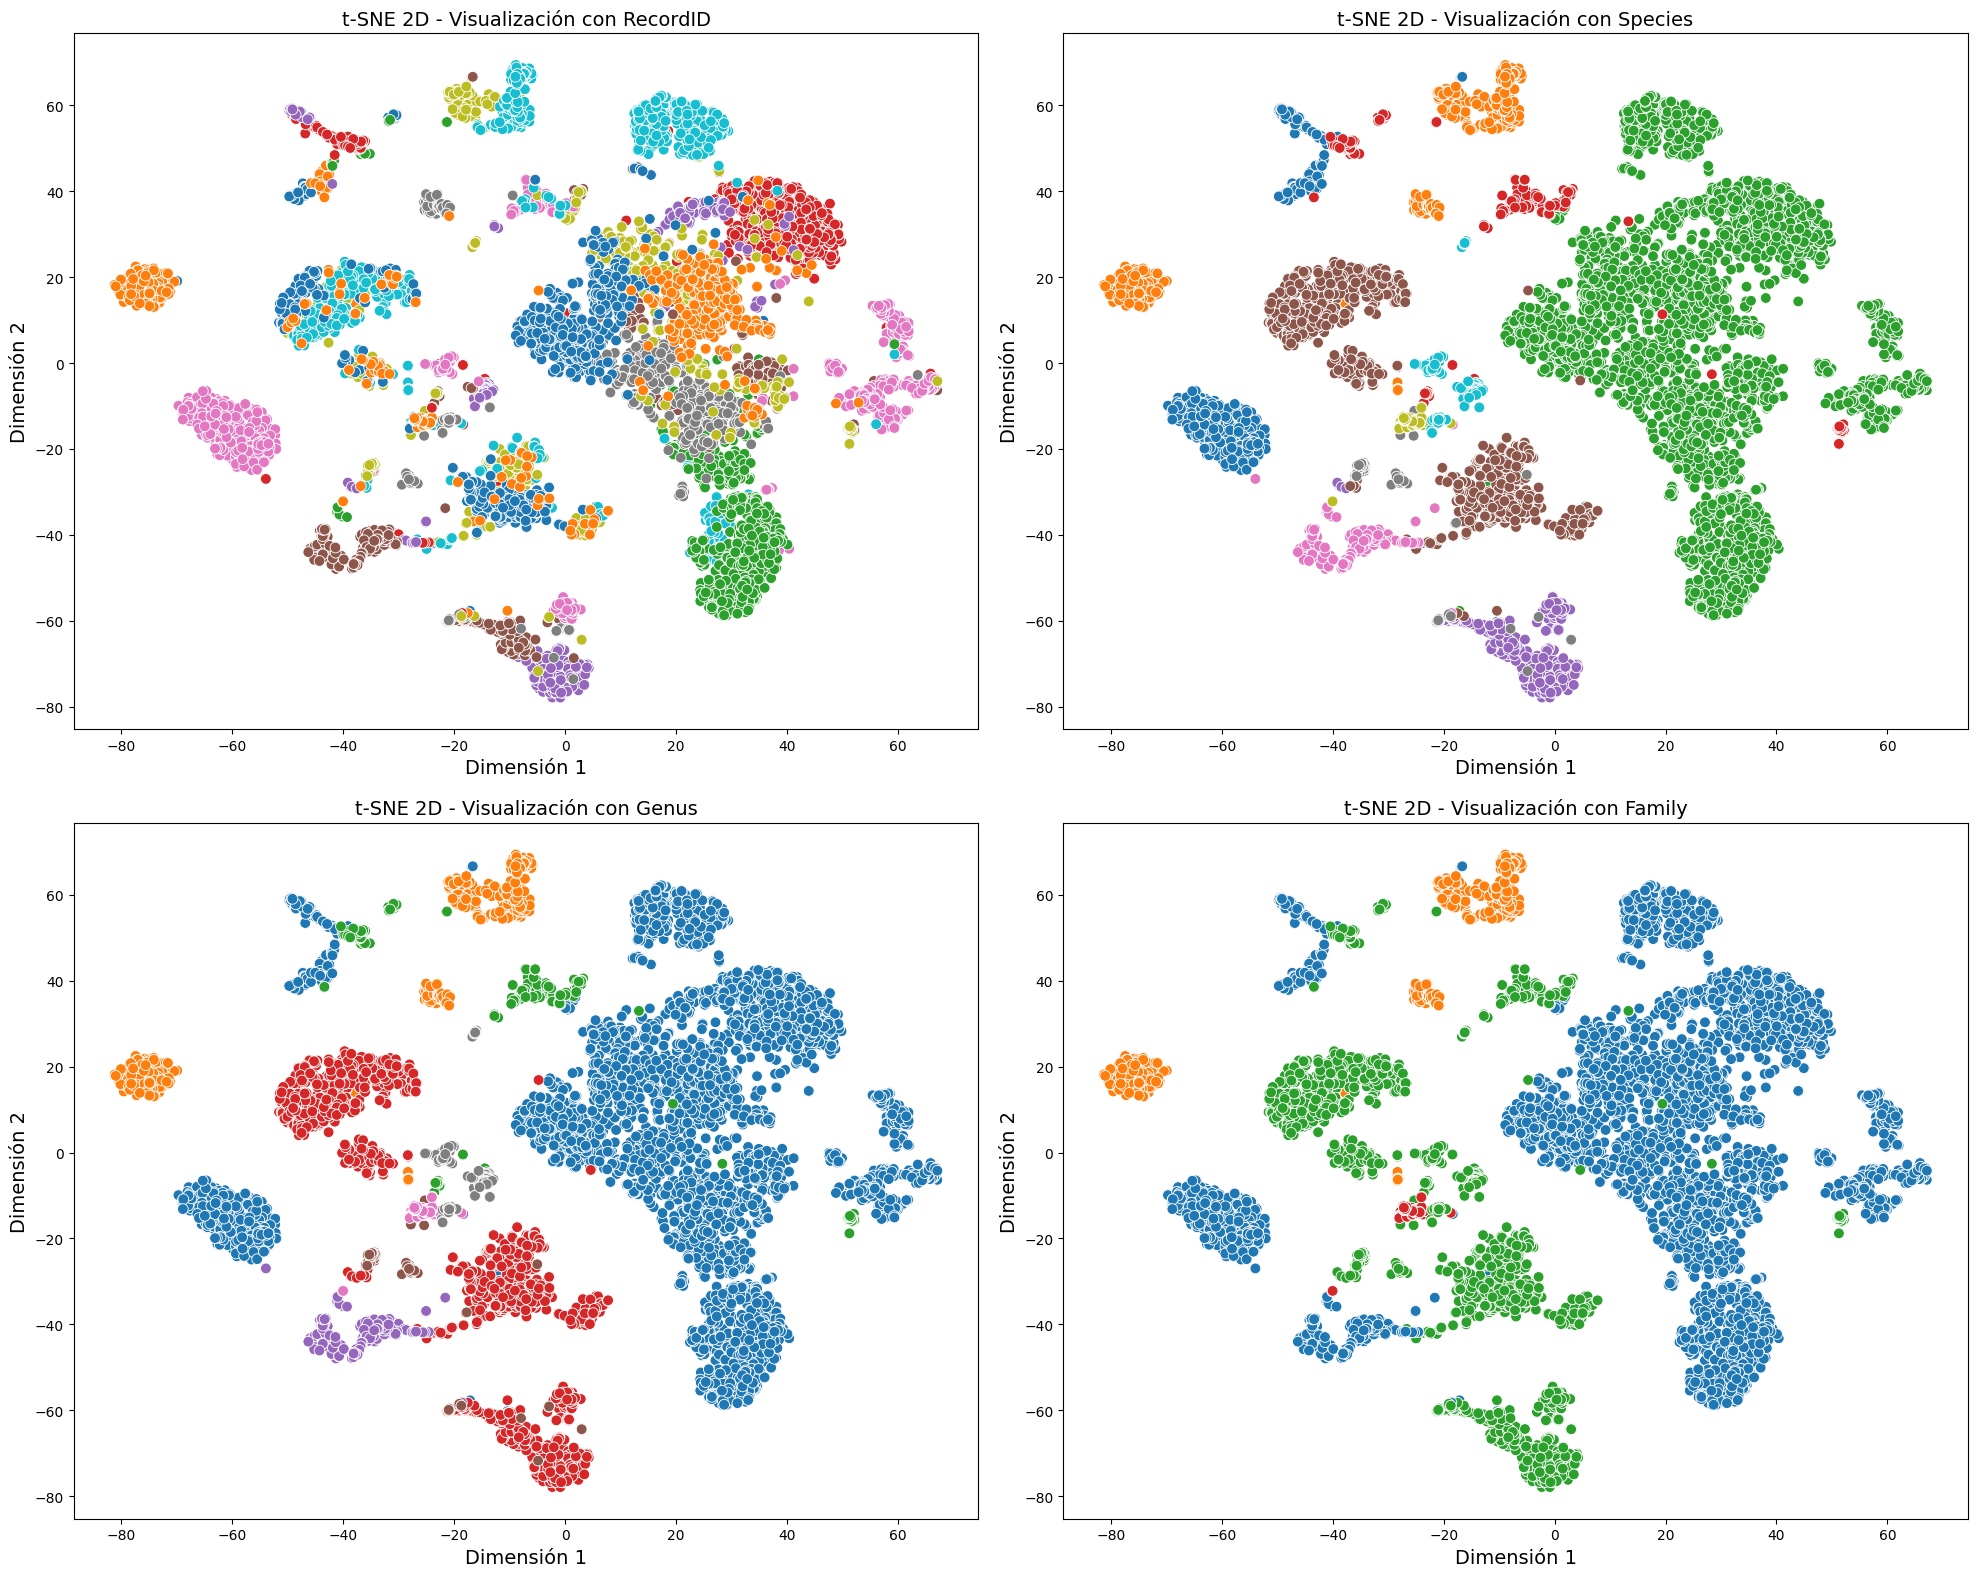

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(20,16))

sns.scatterplot(x=tsne_2d_result[:, 0], y=tsne_2d_result[:, 1], hue=labels_outliers, palette="tab10", s=60, legend=False, ax=axes[0, 0])
axes[0, 0].set_title("t-SNE 2D - Visualización con RecordID")
axes[0, 0].set_xlabel("Dimensión 1")
axes[0, 0].set_ylabel("Dimensión 2")

sns.scatterplot(x=tsne_2d_result[:, 0], y=tsne_2d_result[:, 1], hue=species_outliers, palette="tab10", s=60, legend=False, ax=axes[0, 1])
axes[0, 1].set_title("t-SNE 2D - Visualización con Species")
axes[0, 1].set_xlabel("Dimensión 1")
axes[0, 1].set_ylabel("Dimensión 2")

sns.scatterplot(x=tsne_2d_result[:, 0], y=tsne_2d_result[:, 1], hue=genus_outliers, palette="tab10", s=60, legend=False, ax=axes[1, 0])
axes[1, 0].set_title("t-SNE 2D - Visualización con Genus")
axes[1, 0].set_xlabel("Dimensión 1")
axes[1, 0].set_ylabel("Dimensión 2")

sns.scatterplot(x=tsne_2d_result[:, 0], y=tsne_2d_result[:, 1], hue=family_outliers, palette="tab10", s=60, legend=False, ax=axes[1, 1])
axes[1, 1].set_title("t-SNE 2D - Visualización con Family")
axes[1, 1].set_xlabel("Dimensión 1")
axes[1, 1].set_ylabel("Dimensión 2")

plt.tight_layout()
plt.show()

Observando los resultados de la reducción de dimensionalidad mediante t-SNE en 2D, se evidencia también una separación clara de un grupo específico de individuos respecto al resto del conjunto de datos. Esta técnica enfatiza las relaciones locales, lo que permite captar patrones de similitud más complejos que en PCA. En este caso, la separación observada sugiere una estructura de agrupamiento que puede estar más alineada con una clasificación en función de la especie de las ranas, ya que los individuos de una misma especie tienden a agruparse más naturalmente en el espacio reducido. Esto sugiere que t-SNE permite visualizar con más claridad los subgrupos que corresponden a diferencias a nivel de especie.

Para el resto de los individuos, que aparecen en una región más común del espacio t-SNE, se observa una organización algo dispersa pero con ciertas concentraciones locales. Estos patrones podrían indicar subgrupos dentro de géneros o familias que, aunque no son tan claramente diferenciables como las especies, aún muestran relaciones internas. En particular, el enfoque de t-SNE ayuda a destacar estas agrupaciones más sutiles, que podrían ser menos evidentes en técnicas lineales, lo cual es útil para observar posibles relaciones entre individuos de distintos géneros.

La visualización de t-SNE en 2D sugiere que, entre las clasificaciones posibles, el nivel de especie es el que genera la estructura más definida en los datos, separando de forma más clara los distintos subgrupos en el espacio reducido. Esto se refleja en la mayor coherencia y separación entre los puntos correspondientes a cada especie, en comparación con las clasificaciones de familias o géneros, que aparecen mezcladas con otros subgrupos en el espacio. Es decir, la diferenciación observada en t-SNE indica que la estructura interna del dataset puede estar mejor representada mediante una clasificación por especie, ya que las instancias de una misma especie tienden a mantenerse agrupadas incluso cuando se enfatizan relaciones locales.

En conclusión, los resultados de t-SNE en 2D sugieren que, al igual que en PCA 3D, la separación más evidente entre los datos corresponde a una clasificación a nivel de especie. Esto apoya la idea de que, en este conjunto de datos, la especie representa un criterio de agrupación más distintivo que el género o la familia, posiblemente porque las especies captan con mayor precisión las diferencias sutiles entre individuos que otros niveles taxonómicos.

### Experimentación algoritmos

#### K-Means

In [17]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import Birch
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

Ahora vamos a utilizar diferentes algoritmos de clustering para tratar de encontrar aquellos que mejor se ajusten a nuestro conjunto de datos.

Uno de los algoritmos que utilizaremos será el de K-Means, para el cual haremos uso de los distintos hiperparámetros, tratando de buscar cuáles son aquellos que nos dan un mejor rendimiento en nuestro problema.

In [22]:
# Configuraciones para probar diferentes inicializaciones
kmeans_configs = [
    {'name': 'k-means++', 'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'tol': 1e-4, 'algorithm': 'elkan'},
    {'name': 'random', 'init': 'random', 'n_init': 10, 'max_iter': 500, 'tol': 1e-5, 'algorithm': 'lloyd'},
    {'name': 'k-means++_low_iter', 'init': 'k-means++', 'n_init': 20, 'max_iter': 100, 'tol': 1e-3, 'algorithm': 'elkan'},
    {'name': 'random_high_tolerance', 'init': 'random', 'n_init': 5, 'max_iter': 300, 'tol': 1e-2, 'algorithm': 'lloyd'}
]

# Rango de número de clusters que se probarán
cluster_range = [4, 8, 10, 60]

# Array de diferentes conjuntos de características para cada iteración
outliers_list = [family_outliers, genus_outliers, species_outliers, labels_outliers]

# Definimos sample_size para acelerar el cálculo
sample_size = 1000

for config in kmeans_configs:
    for i, k in enumerate(cluster_range):
        # Crear el modelo con la configuración actual de la iteración
        kmeans = KMeans(
            n_clusters=k,
            init=config['init'],
            n_init=config['n_init'],
            max_iter=config['max_iter'],
            tol=config['tol'],
            algorithm=config['algorithm'],
            random_state=42
        )
        kmeans.fit(pca_2d_result)

        # Obtener las etiquetas de los clusters
        labels = kmeans.labels_

        # Usar el conjunto de características correspondiente para el cálculo del Silhouette Score
        silhouette_avg = silhouette_score(pca_2d_result, labels, sample_size=sample_size)
        print(f"Silhouette score ({config['name']}, k={k}): {silhouette_avg}")
        db_index = davies_bouldin_score(pca_2d_result, labels)
        print(f"Índice Davies-Bouldin ({config['name']}, k={k}): {db_index}")
        ari_score = adjusted_rand_score(family_outliers, labels)
        print(f"Adjusted Rand Index ({config['name']}): {ari_score}")
        print("________________________")

print("------------------------------------------------------------------------------------")

for config in kmeans_configs:
    for i, k in enumerate(cluster_range):
        # Crear el modelo con la configuración actual de la iteración
        kmeans = KMeans(
            n_clusters=k,
            init=config['init'],
            n_init=config['n_init'],
            max_iter=config['max_iter'],
            tol=config['tol'],
            algorithm=config['algorithm'],
            random_state=42
        )
        kmeans.fit(pca_3d_result)

        # Obtener las etiquetas de los clusters
        labels = kmeans.labels_

        # Usar el conjunto de características correspondiente para el cálculo de las métricas
        silhouette_avg = silhouette_score(pca_3d_result, labels, sample_size=sample_size)
        print(f"Silhouette score ({config['name']}, k={k}): {silhouette_avg}")
        db_index = davies_bouldin_score(pca_3d_result, labels)
        print(f"Índice Davies-Bouldin ({config['name']}, k={k}): {db_index}")
        ari_score = adjusted_rand_score(family_outliers, labels)
        print(f"Adjusted Rand Index ({config['name']}): {ari_score}")
        print("________________________")

Silhouette score (k-means++, k=4): 0.5258835469588787
Índice Davies-Bouldin (k-means++, k=4): 0.6625229520793493
Adjusted Rand Index (k-means++): 0.1967092359161268
________________________
Silhouette score (k-means++, k=8): 0.42624904538002467
Índice Davies-Bouldin (k-means++, k=8): 0.7682966946736081
Adjusted Rand Index (k-means++): 0.21709828873906795
________________________
Silhouette score (k-means++, k=10): 0.4051464042332768
Índice Davies-Bouldin (k-means++, k=10): 0.7921263881015059
Adjusted Rand Index (k-means++): 0.17721861087610163
________________________
Silhouette score (k-means++, k=60): 0.3274966169579252
Índice Davies-Bouldin (k-means++, k=60): 0.8577020448345112
Adjusted Rand Index (k-means++): 0.03415586901954443
________________________
Silhouette score (random, k=4): 0.5173078626530553
Índice Davies-Bouldin (random, k=4): 0.6628597972290143
Adjusted Rand Index (random): 0.196438563804341
________________________
Silhouette score (random, k=8): 0.4400890593776281
Í

En lo referente al algoritmo K-Means, hemos utilizado distintas configuraciones para comprobar el comportamiento del algoritmo haciendo uso de distintos hiperparámetros. Además, hemos hecho uso de los conjuntos transformados a partir del Análisis de Componentes Principales, para ver cuál se adapta mejor al problema, si el bidimensional o el tridimensional.

El análisis de las métricas muestra que los resultados obtenidos con el conjunto bidimensional (2 componentes principales) son consistentemente superiores a los obtenidos con el conjunto tridimensional (3 componentes principales) en todas las configuraciones. Esto indica que la reducción de dimensionalidad a 2 componentes facilita una mejor separación de los datos y permite al algoritmo K-Means realizar una mejor agrupación.
Evaluación de las Configuraciones de K-Means

Ahora, si analizamos los resultados de las distintas configuraciones de k-means para el primer conjunto, vemos que todas las configuraciones nos dan los mejores resultados cuando hacemos uso de 4 clústers, y además, el resultado va empeorando en todas las métricas a medida que aumentamos el número de clústers.

Silhouette Score: La métrica es más alta cuando se utilizan 4 clusters, con un valor de aproximadamente 0.525, lo que sugiere una buena cohesión dentro de los clusters y separación entre ellos. Sin embargo, a medida que el número de clusters aumenta, el Silhouette Score disminuye, lo que implica que los clusters se vuelven menos definidos.

Índice Davies-Bouldin: Los valores más bajos (alrededor de 0.662) también se obtienen con k=4, lo que reafirma la compacidad y separación adecuada de los clusters en esta configuración. Un aumento en el número de clusters resulta en un mayor valor del índice, lo que indica una peor separación y compacidad.

Adjusted Rand Index (ARI): Esta métrica extrínseca mide la similitud entre las etiquetas reales y las predichas. En el caso de k=4, el ARI es de aproximadamente 0.197, lo que indica una concordancia moderada entre la agrupación generada y las etiquetas reales. A medida que el número de clusters aumenta, el ARI no mejora de manera significativa y, en algunos casos, disminuye drásticamente (como con k=60, donde el ARI es solo 0.034), lo que sugiere que un mayor número de clusters no aporta una mejor correspondencia con la estructura real de los datos.

Esto puede deberse principalmente a posibles relaciones lineales entre datos que no necesariamente se encuentran en regiones similares del espacio bidimensional. En particular, nos referimos a que la mayoría de datos se encontraban aglomeradas en una zona del espacio, sin presentar subgrupos claros, haciendo que sea más difícil realizar subdivisiones del conjunto de individuos en un mayor número de clústers.

El análisis muestra que la configuración de k=4 clusters es la más adecuada en términos de métricas intrínsecas y extrínsecas. El Adjusted Rand Index (ARI), aunque relativamente bajo en todas las configuraciones, proporciona información importante sobre la correspondencia entre la agrupación generada y las etiquetas reales, sugiriendo que una agrupación en 4 clusters ofrece la mejor aproximación al agrupamiento real.

En resumen, k-means++ y k-means++_low_iter con k=4 son opciones destacadas, pero si se busca un poco más de flexibilidad, random_high_tolerance con k=4 también es viable. Configuraciones con un mayor número de clusters no parecen mejorar el rendimiento, y de hecho, el ARI confirma que la agrupación no se corresponde bien con las etiquetas reales a medida que se incrementa el número de clusters.

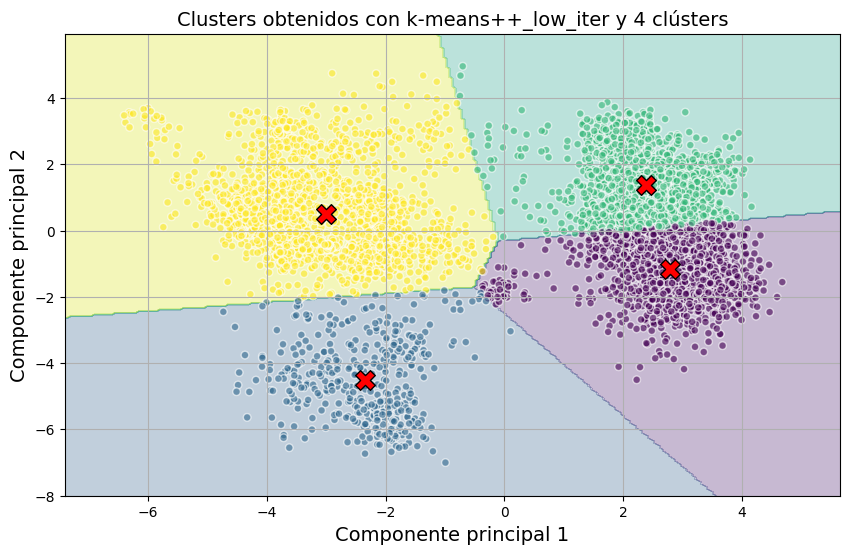

In [25]:
# Crear el modelo con la mejor configuración
kmeans = KMeans(
  n_clusters=4,
  init='k-means++',
  n_init=20,
  max_iter=100,
  tol=1e-3,
  algorithm='elkan',
  random_state=42
)

# Ajustar el modelo usando los datos reducidos a 2 dimensiones (pca_2d_result)
kmeans.fit(pca_2d_result)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Definir los límites del gráfico
x_min, x_max = pca_2d_result[:, 0].min() - 1, pca_2d_result[:, 0].max() + 1
y_min, y_max = pca_2d_result[:, 1].min() - 1, pca_2d_result[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))

# Predecir los clusters para cada punto en la rejilla
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Visualizar las zonas de clusters
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.scatter(pca_2d_result[:, 0], pca_2d_result[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6, edgecolors='w')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', edgecolors='k')
plt.title(f"Clusters obtenidos con k-means++_low_iter y 4 clústers")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()

#### Birch

El segundo algoritmo que vamos a aplicar será el de Birch. Este es un algoritmo jerárquico que trabaja muy bien con datos de alta dimensionalidad y permite una agrupación eficiente gracias a su estructura jerárquica.

In [26]:
# Configuraciones para probar diferentes inicializaciones
birch_configs = [
    {'name': 'Default', 'threshold': 0.5, 'branching_factor': 50},
    {'name': 'Lower threshold', 'threshold': 0.25, 'branching_factor': 50},
    {'name': 'Higher factor', 'threshold': 0.5, 'branching_factor': 100}
]

# Rango de número de clusters que se probarán
cluster_range = [4, 8, 10, 60]

for config in birch_configs:
    for k in cluster_range:
        # Crear el modelo BIRCH con la configuración actual
        birch = Birch(
            n_clusters=k,
            threshold=config['threshold'],
            branching_factor=config['branching_factor']
        )
        birch.fit(pca_3d_result)

        # Obtener las etiquetas de los clusters
        labels = birch.labels_

        # Calcular el Silhouette Score
        silhouette_avg = silhouette_score(pca_3d_result, labels)
        print(f"Silhouette score ({config['name']}, k={k}): {silhouette_avg}")

        # Calcular el Índice Davies-Bouldin
        db_index = davies_bouldin_score(pca_3d_result, labels)
        print(f"Índice Davies-Bouldin ({config['name']}, k={k}): {db_index}")

        # Calcular el Adjusted Rand Index (ARI)
        ari_score = adjusted_rand_score(family_outliers, labels)
        print(f"Adjusted Rand Index ({config['name']}): {ari_score}")
        print("________________________")

Silhouette score (Default, k=4): 0.48063045124811227
Índice Davies-Bouldin (Default, k=4): 0.8211053256568052
Adjusted Rand Index (Default): 0.5135013102030217
________________________
Silhouette score (Default, k=8): 0.363520722474898
Índice Davies-Bouldin (Default, k=8): 0.9018928078387405
Adjusted Rand Index (Default): 0.23588130105115918
________________________
Silhouette score (Default, k=10): 0.3662348623571568
Índice Davies-Bouldin (Default, k=10): 0.9627179775547825
Adjusted Rand Index (Default): 0.2390260325148964
________________________
Silhouette score (Default, k=60): 0.2548561330647747
Índice Davies-Bouldin (Default, k=60): 1.045613919395809
Adjusted Rand Index (Default): 0.08642890490799746
________________________
Silhouette score (Lower threshold, k=4): 0.4759897640847817
Índice Davies-Bouldin (Lower threshold, k=4): 0.7998061947935111
Adjusted Rand Index (Lower threshold): 0.5165290376845904
________________________
Silhouette score (Lower threshold, k=8): 0.34826348

El algoritmo de clustering BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies) ha sido evaluado utilizando distintas configuraciones y diferentes números de clusters para identificar la combinación óptima en términos de calidad de agrupación. Se han analizado las métricas de Silhouette Score, Índice Davies-Bouldin y Adjusted Rand Index (ARI) para comparar el rendimiento y la capacidad del algoritmo de descubrir la estructura de los datos.

El análisis revela que el mejor rendimiento en términos de calidad de clusters se obtiene con k=4 en todas las configuraciones. Esta elección de número de clusters presenta el Silhouette Score más alto y el Índice Davies-Bouldin más bajo, indicando una mejor cohesión interna de los clusters y una adecuada separación entre ellos. La métrica ARI, que mide la similitud entre la agrupación obtenida y las etiquetas reales, también apoya la elección de k=4 como el número de clusters óptimo.

A medida que se incrementa el número de clusters Silhouette Score disminuye, lo que indica que la cohesión interna de los clusters se degrada y los clusters se superponen más. A su vez, el índice Davies-Bouldi aumenta, señalando una peor separación y compacidad de los clusters. Por último ARI tiende a disminuir, lo que sugiere que el resultado de la agrupación se aleja cada vez más de la verdadera estructura de los datos, y el algoritmo puede estar sobreajustando o identificando subgrupos artificiales sin una base real en los datos.

La configuración óptima para BIRCH es la de Lower Threshold (umbral más bajo) con k=4, ya que equilibra la sensibilidad del algoritmo para detectar diferencias significativas entre los datos, manteniendo clusters bien separados y compactos. Aunque la Configuración Higher Factor presenta el ARI más alto, sus otras métricas sugieren una menor cohesión y separación.

El uso de BIRCH con un umbral más bajo y un número de clusters de k=4 es, por tanto, la mejor opción para lograr un equilibrio entre la calidad del clustering y la correspondencia con la estructura real de los datos.

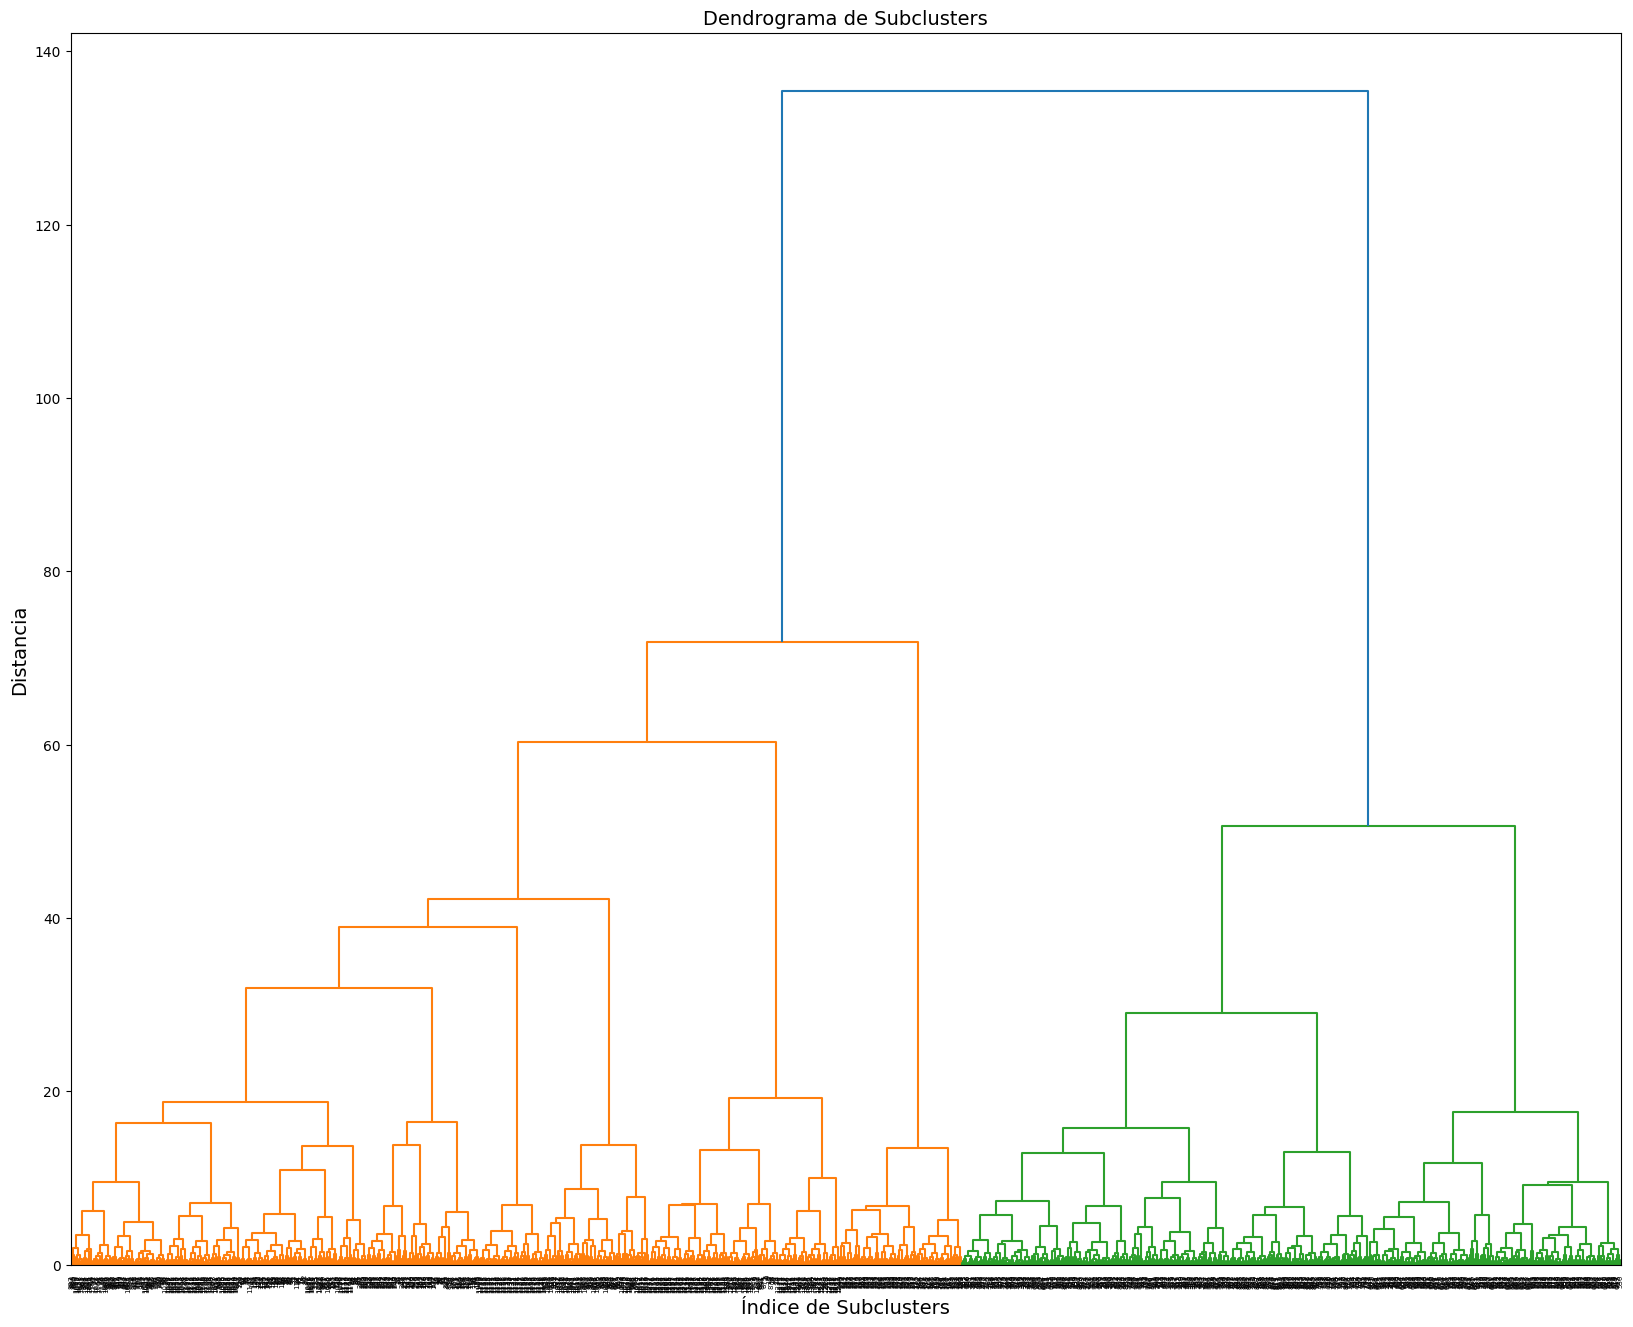

In [27]:
birch = Birch(
    n_clusters=4,
    threshold=0.25,
    branching_factor=50,
    compute_labels=False
)

birch.fit(pca_3d_result)

# Realizar clustering jerárquico sobre los subclusters
linked = linkage(birch.subcluster_centers_, method='ward')

plt.figure(figsize=(20, 16))
dendrogram(
    linked,
    distance_sort='descending',
    show_leaf_counts=True
)
plt.title('Dendrograma de Subclusters')
plt.xlabel('Índice de Subclusters')
plt.ylabel('Distancia')
plt.show()


El dendograma muestra que al cortar a una altura de aproximadamente 60 se obtienen cuatro clústeres óptimos, alineándose con las métricas anteriores y permitiendo una segmentación efectiva y significativa de los datos. Estos clústeres permiten comprender la estructura subyacente de los datos, destacando tanto las similitudes internas como las diferencias entre los grupos. Este análisis es clave para tomar decisiones basadas en agrupaciones y aplicar estrategias específicas según la composición y características de cada clúster.

Como podemos deducir de la ramificación obtenida, y al igual que supusimos durante el análisis exploratorio de los datos, se observa una diferenciación clara entre dos subconjuntos de individuos, mientras que el resto de los mismos no presentan diferencias claras dentro de cada subconjunto.

#### MeanShift

Por último, vamos a hacer uso del algoritmo Mean-shift, ya que nuestro dataset no es excesivamente grande, por tanto, podemos conseguir un resultado positivo sin necesidad de requerir un tiempo de ejecución muy elevado.

In [28]:
# Configuraciones para probar diferentes inicializaciones
meanshift_configs = [
    {'name': '12 bandwidth', 'bandwidth': 12},
    {'name': '14 bandwidth', 'bandwidth': 14},
    {'name': '16 bandwidth', 'bandwidth': 16},
    {'name': '18 bandwidth', 'bandwidth': 18},
    {'name': '20 bandwidth', 'bandwidth': 20}
]

# Supongamos que 'true_labels' contiene las etiquetas reales
# true_labels = ...

for config in meanshift_configs:
    # Crear el modelo con la configuración actual de la iteración
    meanshift = MeanShift(bandwidth=config['bandwidth'])
    meanshift.fit(tsne_2d_result)

    # Obtener las etiquetas de los clusters
    labels = meanshift.labels_

    # Número de clusters
    n_clusters = len(np.unique(labels))
    print(f"Número de clusters ({config['name']}): {n_clusters}")

    # Verificar si hay más de un cluster antes de calcular las métricas
    if n_clusters > 1:
        # Calcular el Silhouette Score
        silhouette_avg = silhouette_score(tsne_2d_result, labels)
        print(f"Silhouette score ({config['name']}): {silhouette_avg}")

        # Calcular el Índice Davies-Bouldin
        db_index = davies_bouldin_score(tsne_2d_result, labels)
        print(f"Índice Davies-Bouldin ({config['name']}): {db_index}")

        # Calcular el Adjusted Rand Index (ARI)
        ari_score = adjusted_rand_score(species_outliers, labels)
        print(f"Adjusted Rand Index ({config['name']}): {ari_score}")
    else:
        print(f"No se puede calcular Silhouette/Davies-Bouldin/ARI para un solo cluster en la configuración {config['name']}")

    print("________________________")


Número de clusters (12 bandwidth): 21
Silhouette score (12 bandwidth): 0.5046439170837402
Índice Davies-Bouldin (12 bandwidth): 0.6900389414742366
Adjusted Rand Index (12 bandwidth): 0.209268827145544
________________________
Número de clusters (14 bandwidth): 19
Silhouette score (14 bandwidth): 0.5299545526504517
Índice Davies-Bouldin (14 bandwidth): 0.6460456490712057
Adjusted Rand Index (14 bandwidth): 0.20587674900606942
________________________
Número de clusters (16 bandwidth): 16
Silhouette score (16 bandwidth): 0.5345519781112671
Índice Davies-Bouldin (16 bandwidth): 0.6043599649936182
Adjusted Rand Index (16 bandwidth): 0.26956324853121455
________________________
Número de clusters (18 bandwidth): 16
Silhouette score (18 bandwidth): 0.5286232829093933
Índice Davies-Bouldin (18 bandwidth): 0.6124771087303161
Adjusted Rand Index (18 bandwidth): 0.26572579123827844
________________________
Número de clusters (20 bandwidth): 12
Silhouette score (20 bandwidth): 0.45500391721725464

El análisis de los resultados obtenidos al ajustar el parámetro bandwidth en el algoritmo de clustering MeanShift revela patrones y conclusiones claras sobre la calidad de los clusters formados. Las métricas empleadas para evaluar el rendimiento incluyen el número de clusters, el Silhouette Score, el Índice Davies-Bouldin, y el Adjusted Rand Index (ARI). A continuación, se presenta un análisis detallado y una comparación de las distintas configuraciones.

La primera observación es que el número de clusters detectados disminuye a medida que se incrementa el bandwidth. Esta reducción es esperada, ya que un bandwidth mayor implica una mayor región de influencia en el espacio de características, fusionando más puntos en clusters más grandes y menos numerosos. Esto indica que a medida que se incrementa el bandwidth, la definición entre los clusters se difumina y se tienden a unir grupos de datos.

Por otro lado, el mejor Silhouette Score se obtiene con bandwidth=16, con un valor de 0.5346, sugiriendo un buen equilibrio entre la cohesión y la separación de los clusters. Las configuraciones de bandwidth=14 y 18 también obtienen puntajes superiores a 0.5, lo que implica clusters bien definidos.Sin embargo, con bandwidth=20, el Silhouette Score baja a 0.4550, indicando una pérdida en la claridad de los clusters.

Por su parte, el mejor índice Davies-Bouldin se consigue con bandwidth=16 y es de 0.6044, coincidiendo con el mejor Silhouette Score, lo que sugiere clusters compactos y bien separados.

Por contra, el mejor ARI se logra con bandwidth=20, con un valor de 0.3131, indicando la mayor concordancia con las etiquetas reales. Aunque el bandwidth=20 tiene el ARI más alto, esto es debido a que el número de clusters se aproxima más al número de especies que encontramos en las etiquetas con las que hemos comparado el resultado de la agrupación. Las otras métricas sugieren que la calidad general de los clusters es inferior en esta configuración. El bandwidth=16 ofrece un buen equilibrio entre un ARI moderado y mejores métricas intrínsecas.

Las configuraciones de bandwidth=12 y 14 generan más clusters, pero con menor calidad de cohesión y correspondencia. Por otro lado, bandwidth=20 tiene un ARI alto, pero el Silhouette Score y el Índice Davies-Bouldin indican una menor definición de los clusters, reflejando sobreagrupamiento.

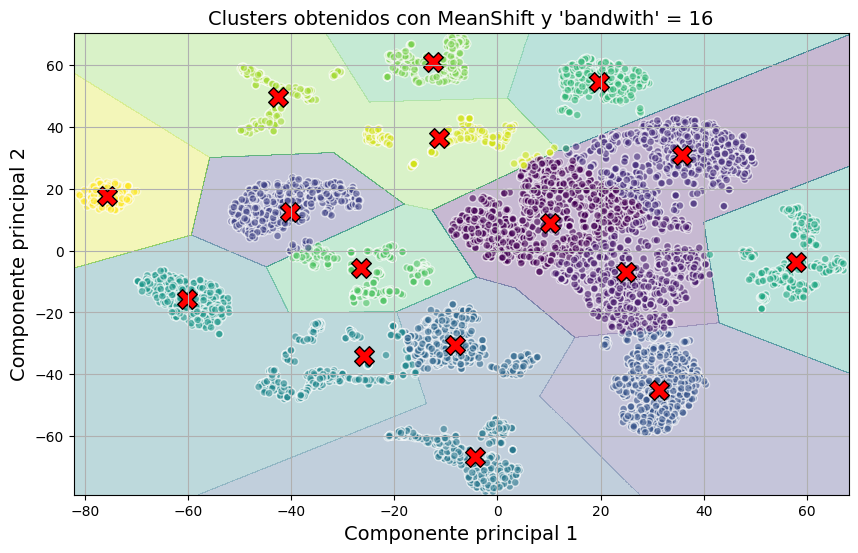

In [29]:
# Crear el modelo con la mejor configuración
meanshift = MeanShift(
  bandwidth = 16
)

# Ajustar el modelo usando los datos reducidos a 2 dimensiones (tsne_2d_result)
meanshift.fit(tsne_2d_result)
labels = meanshift.labels_
centroids = meanshift.cluster_centers_

# Definir los límites del gráfico
x_min, x_max = tsne_2d_result[:, 0].min() - 1, tsne_2d_result[:, 0].max() + 1
y_min, y_max = tsne_2d_result[:, 1].min() - 1, tsne_2d_result[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))

# Predecir los clusters para cada punto en la rejilla
Z = meanshift.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Visualizar las zonas de clusters
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.scatter(tsne_2d_result[:, 0], tsne_2d_result[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6, edgecolors='w')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', edgecolors='k')
plt.title(f"Clusters obtenidos con MeanShift y 'bandwith' = 16")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()

Si comparamos los clusters obtenidos con este algoritmo con las etiquetas que incluye el propio dataset, vemos que la agrupación definida no se ajusta a ninguna de estas, ya que aunque se diferencia claramente cada uno de los clusters, no coinciden con las observaciones que hicimos previamente.

La agrupación se asemeja en el número de clusters a la clasificación por especies, sin embargo, no se agrupan del mismo modo, ya que se subdivide el subconjunto de individuos que identificamos en el análisis exploratorio que eran de una misma especie claramente diferenciada del resto de especies. Por su parte, el resto de clusters si presentan diferencias claras en su componentes y se agrupan de forma algo más precisa.

### Comparación

In [36]:
resultados = {
    'Algoritmo': ['KMeans', 'Birch', 'MeanShift'],
    'Número de clusters': [4, 4, 16],
    'Silhouette Score': [0.5248, 0.4760, 0.5346],
    'Índice Davies-Bouldin': [0.6630, 0.7998, 0.6044],
    'Adjusted Rand Index (ARI)': [0.1969, 0.5165, 0.2696]
}

# Crear el DataFrame
df_resultados = pd.DataFrame(resultados)

# Formatear la tabla con estilo
styled_table = df_resultados.style.format({
    'Silhouette Score': '{:.4f}',
    'Índice Davies-Bouldin': '{:.4f}',
    'Adjusted Rand Index (ARI)': '{:.4f}'
}).set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', 'blue'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('text-align', 'center')]},
    {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', 'dark')]}
]).set_properties(**{
    'text-align': 'center',
    'border': '1px solid black'
}).set_caption("Comparación de Algoritmos de Clustering")

# Mostrar la tabla con estilo
styled_table


### Conclusiones

En este estudio, se han evaluado tres algoritmos de clustering: KMeans, Birch y MeanShift. Cada algoritmo ha sido configurado para encontrar la mejor agrupación posible de los datos, y se han analizado varias métricas de calidad de clustering, como el Silhouette Score, el Índice Davies-Bouldin, y el Adjusted Rand Index (ARI), que proporciona una medida extrínseca de la similitud con las etiquetas reales.

**KMeans**

Silhouette Score: Con un valor de 0.5248, el algoritmo KMeans mostró una cohesión interna y separación entre los clusters bastante buena. Este valor indica que los datos dentro de cada cluster están cerca entre sí y bien diferenciados de los clusters vecinos.
Índice Davies-Bouldin: Un valor de 0.6630 refuerza la idea de una buena compactación y separación de los clusters. Un índice relativamente bajo implica que los clusters están bien definidos y son compactos.
ARI: El ARI de 0.1969 es el más bajo de los tres algoritmos, lo que sugiere que la correspondencia entre la agrupación de KMeans y las etiquetas reales es moderada y podría mejorar. Esto indica que, aunque el clustering es internamente coherente, no representa perfectamente la estructura verdadera de los datos.

Este algoritmo proporciona un buen balance en métricas intrínsecas, lo que lo hace adecuado cuando se busca una agrupación rápida y bien definida, aunque la correspondencia con etiquetas reales es limitada.

**Birch**

Silhouette Score: El valor de 0.4760 es más bajo que el de KMeans y MeanShift, lo que implica una menor cohesión interna de los clusters. Esto puede deberse a la forma en que Birch agrupa los datos mediante una estructura jerárquica basada en un umbral de distancias.
Índice Davies-Bouldin: Con un valor de 0.7998, Birch presenta clusters menos compactos y peor separados en comparación con los otros algoritmos, lo que sugiere una ligera falta de precisión en la formación de clusters.
ARI: A pesar de las métricas intrínsecas más bajas, Birch alcanza el mejor ARI de 0.5165, lo que indica que este algoritmo se aproxima más a la estructura real de los datos. Esto refuerza la idea de que Birch es efectivo cuando se buscan resultados que correspondan a una clasificación real.

Aunque Birch no tiene las mejores métricas intrínsecas, su alto ARI lo hace ideal para problemas donde la similitud con etiquetas reales es fundamental. Su capacidad para detectar estructuras naturales en los datos lo convierte en una buena opción para datasets complejos.

**MeanShift**

Silhouette Score: MeanShift obtiene el mejor Silhouette Score de 0.5346, lo que indica una excelente cohesión y separación de los clusters. Este resultado sugiere que los datos están agrupados de forma clara y bien definida.
Índice Davies-Bouldin: Con el índice más bajo de 0.6044, MeanShift demuestra que sus clusters son los más compactos y están mejor separados entre sí. Esto refleja una alta calidad de la estructura de los clusters.
ARI: El ARI de 0.2696 es superior al de KMeans pero inferior al de Birch, lo que implica que la correspondencia con las etiquetas reales es aceptable, pero no óptima.

Este algoritmo es ideal para problemas donde se necesita la máxima calidad de clusters en términos de cohesión y separación. Sin embargo, la correspondencia con la estructura real de los datos es menor en comparación con Birch, lo que lo hace más adecuado para situaciones donde las etiquetas reales no son un factor decisivo.

En resumen, comparando los resultados de los tres algoritmos, sacamos las siguientes conclusiones:


*   **KMeans** es una opción sólida si se busca un equilibrio entre simplicidad y calidad de los clusters, aunque puede no representar perfectamente la estructura subyacente de los datos.
*   **Birch** destaca en el ARI, lo que sugiere una mayor similitud con las etiquetas reales. Es ideal para datasets con una estructura compleja donde se busca reflejar la verdad subyacente de la clasificación.
*   **MeanShift** es la mejor opción en términos de métricas intrínsecas como el Silhouette Score y el Índice Davies-Bouldin, lo que indica clusters bien definidos y separados. Sin embargo, si la correspondencia con las etiquetas reales es crítica, Birch podría ser preferible.  

#### Conclusiones biológicas

Tras aplicar diferentes algoritmos de clustering al dataset, es importante analizar si los clusters obtenidos reflejan de manera significativa la taxonomía real de los datos. Dado que el dataset contiene 4 familias, 8 géneros, y 10 especies, la comparación entre los clusters formados y estas categorías taxonómicas permite evaluar la relevancia biológica del análisis.

Los resultados muestran que el mejor número de clusters identificado en varios algoritmos (por ejemplo, k=4 para KMeans y Birch, y 16 clusters para MeanShift) podría reflejar la estructura de las familias en el dataset. Dado que hay 4 familias en total, la configuración de k=4 podría indicar una agrupación que tiene en cuenta la distribución de las familias. Sería interesante analizar cuántas de las observaciones en cada cluster pertenecen a la misma familia para determinar si hay una correspondencia clara.

Con 8 géneros en el dataset, los resultados de algoritmos que formaron más de 8 clusters, como MeanShift con 16 clusters, podrían representar subgrupos dentro de los géneros. Este resultado sugiere que el algoritmo es capaz de detectar patrones más finos que podrían relacionarse con subcategorías biológicas más específicas que las familias, agrupando observaciones que comparten características dentro de un género pero que podrían diferir en otros aspectos.

El hecho de que algunos algoritmos (especialmente MeanShift con 16 clusters) produzcan un número de clusters similar al de las 10 especies del dataset sugiere la posibilidad de que los clusters puedan reflejar la distribución y variabilidad a nivel de especies. Analizar la distribución de especies en los clusters podría ayudar a identificar si el clustering captó características distintivas que separan una especie de otra.

El Adjusted Rand Index (ARI) más alto se obtuvo con la configuración de Birch, lo que indica que este algoritmo podría estar capturando patrones que se corresponden mejor con la estructura taxonómica. Esto sugiere que Birch podría estar encontrando agrupaciones que reflejan aspectos biológicos importantes, como diferencias entre géneros o familias.

En el caso de MeanShift, con un ARI moderado de 0.2696 y un alto número de clusters, podríamos estar viendo una separación más granular que captura subgrupos dentro de las especies o incluso diferencias a nivel de registros individuales.

Relación con la Familia: Los resultados de clustering que producen 4 clusters sugieren una buena correspondencia con la estructura de familias. Esto implica que los algoritmos son capaces de identificar diferencias significativas en los datos que podrían estar relacionadas con esta categoría.

### Bibliografía

[1] E. N. Juan Colonna, “Anuran Calls (MFCCs).” UCI Machine Learning Repository, 2015. doi: 10.24432/C5CC9H. https://archive.ics.uci.edu/dataset/406/anuran+calls+mfccs

[2] “3.8. The cepstrum, mel-cepstrum and mel-frequency cepstral coefficients (MFCCs) — Introduction to Speech Processing.” Accessed: Jan. 13, 2024. [Online]. Available: https://speechprocessingbook.aalto.fi/Representations/Melcepstrum.html#the-cepstrum